In [1]:

# %config IPCompleter.greedy=True
import pandas as pd
import seaborn as sns
import numpy as np
import pickle
from xgboost import XGBClassifier
import random

import matplotlib as matplot
import matplotlib.pyplot as plt
# %matplotlib inline
import torch
from torch import nn
from torch.nn import functional as F
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

import warnings, os 
# warnings.filterwarnings("ignore")

# from keras import Sequential
# from keras.models import Model, load_model
# from keras.layers import *
# from keras.callbacks import ModelCheckpoint
# from keras import regularizers
from matplotlib import pyplot as plt

from sklearn.metrics import *
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, VotingClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

from sklearn.feature_selection import RFE
from sklearn.decomposition import PCA, TruncatedSVD, PCA
from sklearn.svm import LinearSVC

import xgboost
# from mlxtend.classifier import EnsembleVoteClassifier 
# import shap
import sklearn.neighbors

from deepod.models import PReNet
from collections import Counter
# from modAL.models impor ActiveLearner, Committee
from sklearn.preprocessing import StandardScaler, RobustScaler, QuantileTransformer, MinMaxScaler
import copy
from itertools import combinations, product
from sklearn.datasets import make_classification
# from alipy import ToolBox
# from alipy.utils.misc import nsmallestarg, randperm, nlargestarg

### Preprocess Data

In [2]:
# dataset_csv_path = './Dataset/CSECICIDS2018_improved'
dataset_csv_path = './Dataset/CICIDS2017_improved'
csv_file_names = os.listdir(dataset_csv_path)[:]
def clean_df(df):
    # Remove the space before each feature names
    df.columns = df.columns.str.strip()
    print('dataset shape', df.shape)

    # This set of feature should have >= 0 values
    num = df._get_numeric_data()
    num[num < 0] = 0

    zero_variance_cols = []
    for col in df.columns:
        if len(df[col].unique()) == 1:
            zero_variance_cols.append(col)
    df.drop(zero_variance_cols, axis = 1, inplace = True)
    print('zero variance columns', zero_variance_cols, 'dropped')
    print('shape after removing zero variance columns:', df.shape)

    df.replace([np.inf, -np.inf], np.nan, inplace = True)
    print(df.isna().any(axis = 1).sum(), 'rows dropped')
    df.dropna(inplace = True)
    print('shape after removing nan:', df.shape)

    # Drop duplicate rows
    df.drop_duplicates(inplace = True)
    print('shape after dropping duplicates:', df.shape)

    column_pairs = [(i, j) for i, j in combinations(df, 2) if df[i].equals(df[j])]
    ide_cols = []
    for column_pair in column_pairs:
        ide_cols.append(column_pair[1])
    df.drop(ide_cols, axis = 1, inplace = True)
    print('columns which have identical values', column_pairs, 'dropped')
    print('shape after removing identical value columns:', df.shape)
    return df
def read_csv():
    complete_paths = []
    for csv_file_name in csv_file_names:
        complete_paths.append(os.path.join(dataset_csv_path, csv_file_name))

    improved_df = pd.concat(map(pd.read_csv, complete_paths), 
                            ignore_index = True)
    dropping_cols = ['Protocol', 'id', 'Flow ID', 'Src IP', 'Src Port', 'Dst IP', 
                    'Dst Port', 'Timestamp']    
    improved_df = clean_df(improved_df)
    improved_df.drop(dropping_cols, axis = 1, inplace = True)
    improved_df['Label'].value_counts()    
    return improved_df

def sample_df(curr_df, anomaly_rate):
    num_benign = len(curr_df.loc[curr_df['Label'] == "BENIGN"])
    num_attack = len(curr_df) - num_benign
    ratio = num_attack / num_benign
    
    if ratio > anomaly_rate:
        sample = anomaly_rate * num_benign / num_attack
        sampled_df = pd.concat([curr_df[curr_df['Label'] == 'BENIGN'], 
                                curr_df[curr_df['Label'] != 'BENIGN'].sample(frac=sample, random_state=42)]) 
    else:
        
        sample = (1/anomaly_rate) * num_attack / num_benign
        sampled_df = pd.concat([curr_df[curr_df['Label'] != 'BENIGN'], 
                                curr_df[curr_df['Label'] == 'BENIGN'].sample(frac=sample, random_state=42)]) 
    
    new_ratio = sampled_df.loc[sampled_df["Label"] == "BENIGN"].shape[0] / sampled_df.loc[sampled_df["Label"] != "BENIGN"].shape[0]
    
    return sampled_df

def preprocess_data(df, train_perc=0.15, random_state=42):
    # Make a copy of the dataframe
    improved_df = df.copy()
    
    # Clean the labels
    #* Remove Attack data labeled as Benign
    # attepmted_labels = [s for s in improved_df['Label'].unique() if 'Attempted' in s]
    # improved_df.drop(['Attempted Category'], axis=1, inplace=True)
    # improved_df.replace(attepmted_labels, 'BENIGN', inplace=True)
    #* --

    # Sample the anomaly rate
    # print(f"improved_df.shape {improved_df.shape} Before Sampling Out")
    # improved_df = sample_df(improved_df, anomaly_rate)
    # print(f"improved_df.shape {improved_df.shape} after Sampling Out")
    # ratio = improved_df.loc[improved_df["Label"] == "BENIGN"].shape[0] / improved_df.loc[improved_df["Label"] != "BENIGN"].shape[0]
    # print(f"Ratio of Benign to Anomaly is {ratio:.2f} : 1")
    
    # Prepare features and labels
    scaler = StandardScaler()
    Y = improved_df['Label'].map({"BENIGN": 0}).fillna(1)  # Map BENIGN to 0 and others to 1
    X = improved_df.drop(columns=["Label"], axis=1)
    X_scaled = scaler.fit_transform(X)
    X_scaled = pd.DataFrame(X_scaled, columns=X.columns)

    # Train-test split
    X_train, X_test, y_train, y_test = train_test_split(
        X_scaled, 
        Y, 
        test_size=1-train_perc, 
        shuffle=True, 
        stratify=Y, 
        random_state=random_state
    )
    
    return X_train, X_test, y_train, y_test

def balance_attack(df, atk_list, verbose=0):
    atk_list = ["Portscan", "DoS Hulk", "DDoS", "Infiltration - Portscan", "DoS GoldenEye", "FTP-Patator", "DoS Slowloris", "SSH-Patator", "DoS Slowhttptest"]
    reduced_cicids_df = pd.DataFrame()
    for atk_name in atk_list:
        temp_df = df.loc[df["Label"] == atk_name]
        temp_df = temp_df.sample(n=min(temp_df.shape[0], 10_000))
        reduced_cicids_df = pd.concat([reduced_cicids_df, temp_df], ignore_index=True)
    
    benign_df = df.loc[df["Label"] == 'BENIGN']
    reduced_cicids_df = pd.concat([reduced_cicids_df, benign_df], ignore_index=True)
        
    if verbose:
        print(reduced_cicids_df["Label"].value_counts())
    return reduced_cicids_df
    
    
        
#* Usage
# read_csv() => balance_attack => define_atk / preprocess_data() =>Train()
atk_list = ["Portscan", "DoS Hulk", "DDoS", "Infiltration - Portscan", "DoS GoldenEye", "FTP-Patator", "DoS Slowloris", "SSH-Patator", "DoS Slowhttptest"]
cicids_df = read_csv()
reduced_cicids_df = balance_attack(cicids_df, atk_list, verbose=1)
cicids_df = reduced_cicids_df.copy()
# X_gm_train, X_gm_test, y_gm_train, y_gm_test = preprocess_data(reduced_cicids_df, train_perc=0.99, anomaly_rate)

dataset shape (2099976, 91)
zero variance columns [] dropped
shape after removing zero variance columns: (2099976, 91)
5 rows dropped
shape after removing nan: (2099971, 91)
shape after dropping duplicates: (2099971, 91)
columns which have identical values [] dropped
shape after removing identical value columns: (2099971, 91)
Label
BENIGN                     1582561
Portscan                     10000
DoS Hulk                     10000
DDoS                         10000
Infiltration - Portscan      10000
DoS GoldenEye                 7567
FTP-Patator                   3972
DoS Slowloris                 3859
SSH-Patator                   2961
DoS Slowhttptest              1740
Name: count, dtype: int64


In [3]:
cicids_df['Label'].value_counts()
cicids_df['Attempted Category'].value_counts()
attepmted_labels = [s for s in cicids_df['Label'].unique() if 'Attempted' in s]

cicids_df.drop(['Attempted Category'], axis = 1, inplace = True)

cicids_df.replace(attepmted_labels, 'BENIGN', inplace = True)
cicids_df['Label'].value_counts()

Label
BENIGN                     1582561
Portscan                     10000
DoS Hulk                     10000
DDoS                         10000
Infiltration - Portscan      10000
DoS GoldenEye                 7567
FTP-Patator                   3972
DoS Slowloris                 3859
SSH-Patator                   2961
DoS Slowhttptest              1740
Name: count, dtype: int64

Attempted Category
0    1642660
Name: count, dtype: int64

Label
BENIGN                     1582561
Portscan                     10000
DoS Hulk                     10000
DDoS                         10000
Infiltration - Portscan      10000
DoS GoldenEye                 7567
FTP-Patator                   3972
DoS Slowloris                 3859
SSH-Patator                   2961
DoS Slowhttptest              1740
Name: count, dtype: int64

In [4]:
# Shuffle the Benign Data
benign_df = cicids_df.loc[cicids_df["Label"] == "BENIGN"]
benign_df = benign_df.sample(frac=1).reset_index(drop=True)
benign_df

,Flow Duration,Total Fwd Packet,Total Bwd packets,Total Length of Fwd Packet,Total Length of Bwd Packet,Fwd Packet Length Max,Fwd Packet Length Min,Fwd Packet Length Mean,Fwd Packet Length Std,Bwd Packet Length Max,...,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,ICMP Code,ICMP Type,Total TCP Flow Time,Label
0,99039,5,5,236,145,236,0,47.200000,105.542409,92,...,0,0,0.000000e+00,0.000000e+00,0,0,0,0,99039,BENIGN
1,5451085,9,8,348,4555,191,0,38.666667,70.588597,1460,...,0,0,0.000000e+00,0.000000e+00,0,0,0,0,5451085,BENIGN
2,496,1,1,88,166,88,88,88.000000,0.000000,166,...,0,0,0.000000e+00,0.000000e+00,0,0,0,0,0,BENIGN
3,117038578,25,24,1373,16681,357,0,54.920000,127.347595,2920,...,1727844,23525,9.584851e+06,1.421694e+06,10001963,5070683,0,0,117038578,BENIGN
4,5215818,6,3,123,46,46,0,20.500000,23.114930,46,...,0,0,0.000000e+00,0.000000e+00,0,0,0,0,180892068,BENIGN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1582556,344348,7,7,334,3776,208,0,47.714286,84.856181,1460,...,0,0,0.000000e+00,0.000000e+00,0,0,0,0,344348,BENIGN
1582557,5719249,4,2,0,0,0,0,0.000000,0.000000,0,...,15194,15194,5.688948e+06,0.000000e+00,5688948,5688948,0,0,5719249,BENIGN
1582558,115247409,22,22,5229,3337,2920,0,237.681818,700.805481,1400,...,335980,34363,9.989246e+06,4.016369e+04,10011899,9869386,0,0,115247409,BENIGN
1582559,61002,4,2,140,146,35,35,35.000000,0.000000,73,...,0,0,0.000000e+00,0.000000e+00,0,0,0,0,0,BENIGN


### Defining Global and Local Model

In [5]:
def set_supervised_label(supervision_rate, y, idx):
        if supervision_rate == 0:
            y[idx[:2]] = 1
        else:
            idx = np.random.choice(idx, size=int(supervision_rate * len(idx)), replace=False)
            y[idx] = 1
        return y
      
def get_optimal_threshold(precision, recall, thresholds):
    with np.errstate(divide='ignore', invalid='ignore'):
        f1_scores = 2 * (precision * recall) / (precision + recall)
        f1_scores[np.isnan(f1_scores)] = 0  # Replace NaN values with 0    
    optimal_idx = np.argmax(f1_scores)
    optimal_threshold = thresholds[optimal_idx]
    return optimal_threshold  
      
class Global_Model():
  def __init__(self, supervision=1.0, initial_data=None):
      self.initial_data = initial_data.copy() if initial_data else None #Initially Empty
      self.gm_data = None
      self.supervision = supervision
      self.knowledge_pool = []
    #   self.gm_retrain(supervision=1.0)


  def gm_retrain(self, new_gm_data=None, share_knowledge=False):
      if new_gm_data is None:
          training_data = self.initial_data
      else:
          # Combine new data with existing GM data
          self.gm_data = pd.concat([self.gm_data, new_gm_data], ignore_index=True)
          training_data = pd.concat([self.initial_data, self.gm_data], ignore_index=False)
      
      print("GM Training Data Size", training_data.shape)
      label = training_data["Label"]
      training_data = training_data.drop(columns=["Label"])
      # Train-test split
      X_train, X_test, y_train, y_test = train_test_split(
          training_data, label, shuffle=True, test_size=0.2, random_state=4022
      )
      # Prepare labels for semi-supervised learning
      idx = np.where(y_train == 1)[0]
      y_train = np.zeros_like(y_train)  # Initialize with zeros
      y_train = set_supervised_label(self.supervision, y_train, idx)

      # Train the model
      model = PReNet
      self.clf = model(device="cuda", verbose=1, epochs=1, batch_size=64)
      self.clf.fit(X_train.to_numpy(), y=y_train)
      
      # Calculate optimal threshold
      anomaly_scores = self.clf.decision_function(X_test.to_numpy())
      precision, recall, thresholds = precision_recall_curve(y_test, anomaly_scores)
      opt_threshold = get_optimal_threshold(precision, recall, thresholds)
      self.opt_threshold = opt_threshold      

      # Perform inference to evaluate the model
      output, anomaly_scores = self.perform_inference(X_test, y_test)
      if share_knowledge:
        self.share_knowledge(new_gm_data)
    # return clf, model
              
  def perform_inference(self, X, y_real=None):  
      anomaly_scores = self.clf.decision_function(X.to_numpy())
      output = np.where(anomaly_scores > self.opt_threshold, 1,0)
      
      if y_real is not None:
          print("Accuracy of GM: ", accuracy_score(output, y_real))
      return output, anomaly_scores
  def share_knowledge(self, X_new):
    # X_new["Label"] = y_new
    for neigh_area in self.knowledge_pool:
        neigh_model = neigh_area.model
        neigh_model.gm_retrain(X_new, share_knowledge=False)
        # neigh_model.gm_data = pd.concat([neigh_model.lm_data, X_new.copy()], ignore_index=True)
        # neigh_model.model.fit(neigh_model.lm_data.drop(columns=["Label"]), neigh_model.lm_data["Label"])  

In [6]:
class Local_Model():
    def __init__(self, gm):
        self.model = XGBClassifier(objective='binary:logistic', verbosity=0)
        # self.model = DecisionTreeClassifier(criterion='entropy', max_depth=5,  
        #                                     min_samples_leaf=10, 
        #                                     # ccp_alpha=0.01, #Pruning coef
        #                                     random_state=4022)
        self.global_model = gm 
        self.lm_data = pd.DataFrame()
        self.knowledge_pool = []
                
    def retrain_model(self, new_lm_data, threshold = 0.2, update_gm = False): #Select Most Important Data and Upload Newly Recorded Data
        # TODO: Use AL to Select Prerecorded Data
        # known_df = self.load_known_df()
        # filtered_new_data, informative_score_list, updated_model = self.select_data(known_df, X_new, threshold, y_new)
        # labeled_new_data = self.upload_gm(filtered_new_data)
        
        # if update_gm:
        #     filtered_new_data["Label"] = 0
        #     self.global_model.update_data(filtered_new_data)
        # # TODO: After updating return the labels or recall the function
        # else:
        
        y_real = new_lm_data["Label"].copy()
        X_new = new_lm_data.drop(columns=["Label"]).copy()
        X_train, X_test, y_train, y_test = train_test_split(
            X_new, y_real, shuffle=True, test_size=0.2, random_state=4022
        )

        # Use the global model to inquire labels for X_train
        y_new = self.inquire_gm(X_train, y_train)

        # Combine X_train and the inferred labels into a DataFrame
        new_training_data = X_train.copy()
        new_training_data["Label"] = y_new

        # Append new training data to the local model's data
        self.lm_data = pd.concat([self.lm_data, new_training_data], ignore_index=True)

        # Retrain the local model using the updated data
        self.model.fit(self.lm_data.drop(columns=["Label"]), self.lm_data["Label"])

        # Evaluate the updated model (optional, based on your implementation)
        y_pred = self.model.predict(X_test)
        acc = accuracy_score(y_pred, y_test)
        self.share_knowledge(X_train, y_new)

        return acc
    

        
        
    def inquire_gm(self, X_query, y_real=None): 
        # X_query_scaled = self.scaler.transform(X_query)
        pseudo_label, _ = self.global_model.perform_inference(X_query, y_real)
        X_query_df = pd.DataFrame(X_query)
        # X_query_df["Label"] = pseudo_label
        return pseudo_label
    
    def perform_inference(self, X):
        output = self.model.predict(X) 
        return output    
    

### Defining Area

In [19]:
class Attack:
    def __init__(self, name, centroid, std_dev, data):
        self.name = name
        self.centroid = centroid
        self.std_dev = std_dev
        self.data, self.test_data = train_test_split(data, train_size=0.8, random_state=42)
        self.active = False
        self.rr_counter = 0  # Round Robin Counter
        self.first_seen = random.uniform(0,30)

    def get_data(self):
        chunk_size = self.data.shape[0] // 20  # Divide into 10 chunks
        start_idx = self.rr_counter * chunk_size
        end_idx = start_idx + chunk_size
        if self.rr_counter == 9:
            end_idx = self.data.shape[0]  # Include all remaining rows
        self.rr_counter = (self.rr_counter + 1) % 20
        return self.data.iloc[start_idx:end_idx]
        

def define_edge_area(num_edge_area, gm=None, random_state=42, global_sharing=False):
    random.seed(random_state)
    area_list = [Edge_Area((random.uniform(0, 1), random.uniform(0, 1)), Global_Model()) for _ in range(num_edge_area)]
    model = Global_Model()
    for edge_area in area_list:
        centroid = edge_area.centroid
        distances = [
            np.sqrt((other_area.centroid[0] - centroid[0])**2 + (other_area.centroid[1] - centroid[1])**2)
            for other_area in area_list
        ]
        # Get the indices of the two smallest distances, excluding itself
        closest_indices = np.argsort(distances)[1:3]  # Skip the first (distance to itself)
        if gm is not None:
            # edge_area.model.knowledge_pool = [area_list[i] for i in closest_indices] #?Cluster KS
            edge_area.model.knowledge_pool = [] #? No KS
            #* Global Knowledge Sharing
            if global_sharing:
                # local_model = Local_Model(gm) 
                # edge_area.local_model.knowledge_pool = []
                edge_area.model = model
    return area_list

def define_atk(atk_list, edge_area_list, cicids_df, benign_df, random_state=42):
    random.seed(random_state)
    atk_info_dict = {}
    anomaly_ratio = 25
    benign_idx = 0
    for idx, atk in enumerate(atk_list):
        # Cycle through edge areas
        edge_area = edge_area_list[idx % len(edge_area_list)]

        # Define standard deviations
        std_dev = (random.uniform(0.2, 0.4), random.uniform(0.2, 0.4))

        # Offset the attack centroid relative to the edge area centroid
        atk_centroid = (
            edge_area.centroid[0] + random.uniform(-std_dev[0], std_dev[0]) / 3,
            edge_area.centroid[1] + random.uniform(-std_dev[1], std_dev[1]) / 3
        )

        # Filter attack-specific data
        atk_data = cicids_df.loc[cicids_df["Label"] == atk]

        # Get corresponding benign data based on anomaly ratio
        benign_count = atk_data.shape[0] * anomaly_ratio
        benign_data = benign_df.iloc[benign_idx: benign_idx + benign_count]
        benign_idx += benign_count

        # Ensure benign_idx doesn't exceed benign_df bounds
        if benign_idx > len(benign_df):
            benign_idx = len(benign_df)  # Prevent index out of bounds
            print("Index Out of Bounds", atk)

        # Concatenate benign and attack data
        data = pd.concat([benign_data, atk_data], ignore_index=True)
        data = data.sample(frac=1).reset_index(drop=True)
        # data["Label"] = data["Label"].map({"BENIGN": 0}).fillna(1)

        # Create and store an Attack object
        atk_info_dict[atk] = Attack(atk, atk_centroid, std_dev, data)

    return atk_info_dict


class Edge_Area:
    def __init__(self, centroid, gm=None):
        self.centroid = centroid
        self.seen_attack_acc = dict() # Values as List of (t, acc)
        if gm != None:
            self.model = gm
    def create_knowledge_sharing_pool(self):
        # TODO: Get the closest based on euclidean distance
        self.sharing_pool = None



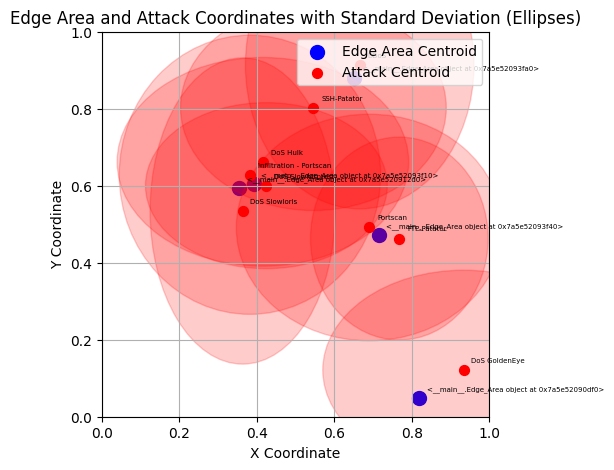

In [8]:
from matplotlib.patches import Ellipse

# Function to visualize edge areas and attack coordinates with standard deviation as ellipses
def visualize_edge_area_and_attacks_with_ellipses(edge_area_list, atk_info_list):
    plt.figure(figsize=(5, 5))
    
    # Plot edge area centroids
    for edge_area in edge_area_list:
        plt.scatter(edge_area.centroid[0], edge_area.centroid[1], c='blue', label='Edge Area Centroid', s=100)
        plt.text(edge_area.centroid[0] + 0.02, edge_area.centroid[1] + 0.02, edge_area, fontsize=5)
    
    # Plot attack centroids with standard deviation
    for attack in atk_info_list:
        plt.scatter(attack.centroid[0], attack.centroid[1], c='red', label='Attack Centroid', s=50)
        plt.text(attack.centroid[0] + 0.02, attack.centroid[1] + 0.02, attack.name, fontsize=5)
        
        # Plot standard deviation as an ellipse around the centroid
        std_x, std_y = attack.std_dev
        ellipse = Ellipse(
            xy=attack.centroid,
            width=2 * std_x,  # Full width of the ellipse
            height=2 * std_y,  # Full height of the ellipse
            edgecolor='red',
            facecolor='red',
            alpha=0.2
        )
        plt.gca().add_patch(ellipse)
    
    # Remove duplicate labels in legend
    handles, labels = plt.gca().get_legend_handles_labels()
    by_label = dict(zip(labels, handles))
    plt.legend(by_label.values(), by_label.keys(), loc="upper right")

    plt.title("Edge Area and Attack Coordinates with Standard Deviation (Ellipses)")
    plt.xlabel("X Coordinate")
    plt.ylabel("Y Coordinate")
    plt.grid(True)
    plt.xlim(0, 1)
    plt.ylim(0, 1)
    plt.show()
    

num_edge_areas = 5
seed = 4028
edge_area_list = define_edge_area(num_edge_areas, random_state=seed)

atk_list = ["Portscan", "DoS Hulk", "DDoS", "Infiltration - Portscan", "DoS GoldenEye", "FTP-Patator", "DoS Slowloris", "SSH-Patator", "DoS Slowhttptest"]
atk_info_dict = define_atk(atk_list, edge_area_list, cicids_df, benign_df, random_state=seed)
visualize_edge_area_and_attacks_with_ellipses(edge_area_list, atk_info_dict.values())


# Bivariate Normal Distribution

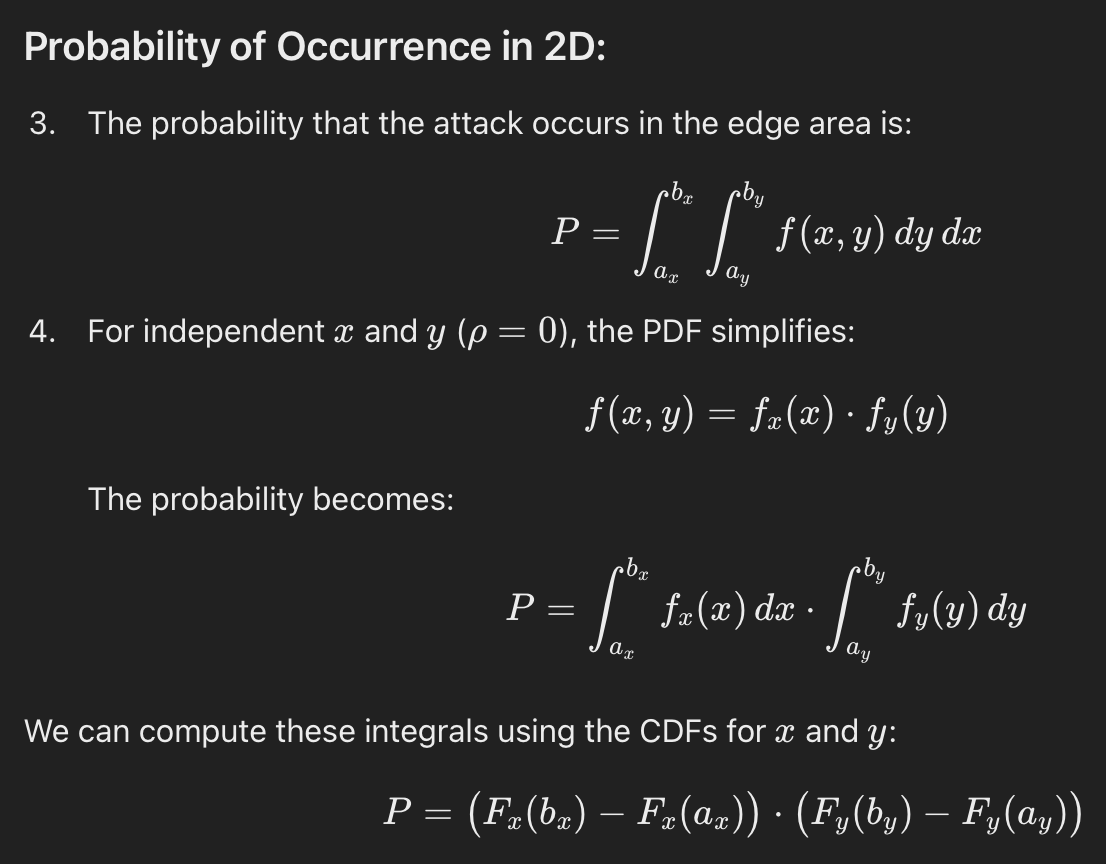

In [9]:
from scipy.stats import norm

def probability_in_2d_edge_area(mu_x, sigma_x, mu_y, sigma_y, area_centroid_x, area_centroid_y):
    (a_x, b_x) = (area_centroid_x-0.1, area_centroid_x+0.1)
    (a_y, b_y) = (area_centroid_y-0.1, area_centroid_y+0.1)

    # Probability in x-dimension
    p_x = norm.cdf(b_x, loc=mu_x, scale=sigma_x) - norm.cdf(a_x, loc=mu_x, scale=sigma_x)
    # Probability in y-dimension
    p_y = norm.cdf(b_y, loc=mu_y, scale=sigma_y) - norm.cdf(a_y, loc=mu_y, scale=sigma_y)

    # Total probability in the 2D region
    return p_x * p_y

# Example usage
mu_x, sigma_x = 0.5, 0.1  # Mean and std deviation for x
mu_y, sigma_y = 0.5, 0.1  # Mean and std deviation for y
area_centroid_x, area_centroid_y = (0.4, 0.4)  # Edge area bounds for x and y

probability = probability_in_2d_edge_area(mu_x, sigma_x, mu_y, sigma_y, area_centroid_x, area_centroid_y)
print(f"Probability of attack occurring in the edge area: {probability:.4f}")


Probability of attack occurring in the edge area: 0.2278


### Initial Training of Local and Global Model

Global Model = 3 Atk, 
Local Model = None

In [26]:
# #### Sample out Malicious data such that it would become an outlier
# print(f'improved_df.shape {cicids_df.shape} Before Sampling Out')
# cicids_df = pd.concat([cicids_df[cicids_df['Label'] == 'BENIGN'], cicids_df[cicids_df['Label'] != 'BENIGN'].sample(frac=0.3, random_state=42)]) 
# print(f'improved_df.shape {cicids_df.shape} after Sampling Out')
ratio = cicids_df.loc[cicids_df["Label"] == "BENIGN"].shape[0]/ cicids_df.loc[cicids_df["Label"] != "BENIGN"].shape[0]
print(f'Ratio of Benign to Anomaly is {ratio} : 1')

Ratio of Benign to Anomaly is 26.332567929582854 : 1


In [27]:
num_edge_areas = 5
edge_area_list = define_edge_area(num_edge_areas)

# atk_list = ["Portscan", "DoS Hulk", "DDoS", "DoS DoS Hulk", "Infiltration - Portscan"]
atk_list = ["Portscan", "DoS Hulk", "DDoS", "Infiltration - Portscan", "DoS GoldenEye", "FTP-Patator", "DoS Slowloris", "SSH-Patator", "DoS Slowhttptest"]
atk_info_dict = define_atk(atk_list, edge_area_list, cicids_df, benign_df)
#TODO: Randomly choose 3 attacks from the list, set the first_seen_t = 0, train the global model using this 3 attacks

In [28]:
# X_gm_train, X_gm_test, y_gm_train, y_gm_test = train_test_split(
#     gm_training_data.drop(columns=["Label"]), gm_training_data["Label"], shuffle=True, test_size=0.2, random_state=4022
# )
# X_gm_train, X_gm_test, y_gm_train, y_gm_test = train_test_split(
#     cicids_df_scaled.drop(columns=["Label"]), cicids_df_scaled["Label"].map({"BENIGN": 0}).fillna(1), shuffle=True, test_size=0.2, random_state=4022
# )
# X_gm_train, X_gm_test, y_gm_train, y_gm_test = preprocess_data(cicids_df)
# X_gm_train, X_gm_test, y_gm_train, y_gm_test = preprocess_data(gm_training_data, train_perc=0.99)

### Start Simulation

Initial GM Training

In [29]:
# TODO: Compare Different Epochs
# atk_list = ["Portscan", "DoS Hulk", "DDoS"]

LIGHT_GREEN = '\033[92m'  # Light green
GREEN = '\033[32m'  # Green
BLUE = '\033[34m'  # Green
PURPLE = '\033[35m'  # Green

RESET = '\033[0m'   # Reset to default color


# Example usage
num_runs = 1
num_timesteps = 300
num_edge_area = 5
supervision = 0.05
global_sharing = False



In [30]:
# To change global or clustering sharing tweak define_edge_area(global_sharing=True/False)
# To change to no knowledge sharing change edge_area.local_model.knowledge_pool to []

In [31]:
from sklearn.exceptions import NotFittedError
import gc

# Main simulation function
final_accuracies = []

for run in range(num_runs):
    print(f"Run {run + 1}/{num_runs}")
    run=run+1

    # Initialize Global Model
    # global_model = Global_Model(gm_training_data[:100000])
    
    # Assign edge area coordinates
    edge_area_list = define_edge_area(5, gm="aaa", random_state=run, global_sharing=global_sharing)

    # Define attack information
    atk_info_list = define_atk(atk_list, edge_area_list, cicids_df, benign_df, random_state=run)

    # Loop through timesteps
    for t in range(num_timesteps):
        for attack in atk_info_list.values():
            # Sample whether an attack is ongoing
            for i, edge_area in enumerate(edge_area_list):
                occ_prob = probability_in_2d_edge_area(attack.centroid[0], attack.std_dev[0], 
                                                        attack.centroid[1], attack.std_dev[1], 
                                                        edge_area.centroid[0], edge_area.centroid[1])
                attack.active = np.random.random() < occ_prob/3
                if attack.active and attack.first_seen < t:
                    # Train local model with a fraction of the data     
                    X_lm_train, X_lm_test, y_lm_train, y_lm_test = preprocess_data(attack.get_data().copy(), train_perc=0.8)                   
                    print(y_lm_train.value_counts(), y_lm_test.value_counts())
                    y_lm_train = y_lm_train.values
                    y_lm_test = y_lm_test.values
                    # Record Accuracy Data
                    X_atk_test, _, y_atk_test, _ = preprocess_data(attack.get_data().copy(), train_perc=0.99)                   
                    y_atk_test = y_atk_test.values
                    
                  

                    try:
                        # Evaluate GM Accuracy
                        y_gm_pred = edge_area.model.perform_inference(X_lm_test)[0]
                        gm_acc = accuracy_score(y_gm_pred, y_lm_test)
                        gm_f1 = f1_score(y_gm_pred, y_lm_test, average='binary')
                        
                        y_gm_atk_pred = edge_area.model.perform_inference(X_atk_test)[0]
                        gm_atk_acc = accuracy_score(y_gm_atk_pred, y_atk_test)
                        gm_atk_f1 = f1_score(y_gm_atk_pred, y_atk_test, average='binary')  
                        

                    except AttributeError as e:
                        # Handle the case where the model is not yet fitted
                        print("Local model is not fitted yet. Please fit the model before inference.")
                        gm_acc = 0
                        gm_f1 = 0
                        
                        gm_atk_acc = 0
                        gm_atk_f1 = 0
                    print(f"Timestep {t}, Area {i} Attack {attack.name}")
                    print(f"{LIGHT_GREEN}Accuracy of GM Before: {gm_acc} {gm_f1} || {gm_atk_acc} {gm_atk_f1} {RESET} ")                            
                    
                    # Update seen_attack_acc
                    if attack.name not in edge_area.seen_attack_acc:
                        edge_area.seen_attack_acc[attack.name] = [(t, gm_atk_acc, gm_atk_f1)]
                    else:
                        edge_area.seen_attack_acc[attack.name].append((t, gm_atk_acc, gm_atk_f1))
                        
                    if gm_f1 < 0.96: #* GM is the bottleneck
                        X_lm_train["Label"] = y_lm_train
                        print("GM New Data Size", X_lm_train.shape[0])
                        edge_area.model.gm_retrain(X_lm_train, share_knowledge=True)
                        y_gm_pred = edge_area.model.perform_inference(X_lm_test)[0]
                        gm_acc = accuracy_score(y_gm_pred, y_lm_test)
                        gm_f1 = f1_score(y_gm_pred, y_lm_test, average='binary')
                        
                        y_gm_atk_pred = edge_area.model.perform_inference(X_atk_test)[0]
                        gm_atk_acc = accuracy_score(y_gm_atk_pred, y_atk_test)
                        gm_atk_f1 = f1_score(y_gm_atk_pred, y_atk_test, average='binary')  
                            
                        print(f"{BLUE}Accuracy of GM After: {gm_acc} {gm_f1} || {gm_atk_acc} {gm_atk_f1} {RESET} ")
                    print(attack.name, X_lm_train.shape)
                    gc.collect()
                    



Run 1/1


Label
0.0    2368
1.0      95
Name: count, dtype: int64 Label
0.0    592
1.0     24
Name: count, dtype: int64
Local model is not fitted yet. Please fit the model before inference.
Timestep 10, Area 2 Attack SSH-Patator
Accuracy of GM Before: 0 0 || 0 0  
GM New Data Size 2463
GM Training Data Size (2463, 82)
Start Training...
ensemble size: 1
epoch  1, training loss: 2.437080, time: 0.0s
Start Inference on the training data...
Accuracy of GM:  0.9939148073022313
Accuracy of GM After: 0.9951298701298701 0.9387755102040817 || 0.9960629921259843 0.952755905511811  
SSH-Patator (2463, 82)


35921

Label
0.0    7995
1.0     325
Name: count, dtype: int64 Label
0.0    1999
1.0      81
Name: count, dtype: int64
Local model is not fitted yet. Please fit the model before inference.
Timestep 14, Area 4 Attack DoS Hulk
Accuracy of GM Before: 0 0 || 0 0  
GM New Data Size 8320
GM Training Data Size (8320, 82)
Start Training...
ensemble size: 1
epoch  1, training loss: 0.679768, time: 0.3s
Start Inference on the training data...
Accuracy of GM:  0.9993990384615384
Accuracy of GM After: 0.9990384615384615 0.9875 || 0.998251578436134 0.9775  
DoS Hulk (8320, 82)


0

Label
0.0    2365
1.0      98
Name: count, dtype: int64 Label
0.0    592
1.0     24
Name: count, dtype: int64
Local model is not fitted yet. Please fit the model before inference.
Timestep 14, Area 1 Attack SSH-Patator
Accuracy of GM Before: 0 0 || 0 0  
GM New Data Size 2463
GM Training Data Size (2463, 82)
Start Training...
ensemble size: 1
epoch  1, training loss: 2.344772, time: 0.0s
Start Inference on the training data...
Accuracy of GM:  0.9939148073022313
Accuracy of GM After: 0.9967532467532467 0.9583333333333334 || 0.9950787401574803 0.9372384937238494  
SSH-Patator (2463, 82)


0

Label
0.0    7992
1.0     328
Name: count, dtype: int64 Label
0.0    1998
1.0      82
Name: count, dtype: int64
Timestep 19, Area 2 Attack DDoS
Accuracy of GM Before: 0.9586538461538462 0.0 || 0.9544439048081593 0.0  
GM New Data Size 8320
GM Training Data Size (10783, 82)
Start Training...
ensemble size: 1
epoch  1, training loss: 0.756589, time: 0.4s
Start Inference on the training data...
Accuracy of GM:  0.999072786277237
Accuracy of GM After: 1.0 1.0 || 0.9950461389023798 0.9387755102040817  
DDoS (8320, 82)


10548

Label
0.0    3170
1.0     134
Name: count, dtype: int64 Label
0.0    792
1.0     34
Name: count, dtype: int64
Local model is not fitted yet. Please fit the model before inference.
Timestep 19, Area 0 Attack FTP-Patator
Accuracy of GM Before: 0 0 || 0 0  
GM New Data Size 3304
GM Training Data Size (3304, 82)
Start Training...
ensemble size: 1
epoch  1, training loss: 1.710533, time: 0.1s
Start Inference on the training data...
Accuracy of GM:  0.9984871406959153
Accuracy of GM After: 0.9987893462469734 0.9850746268656716 || 0.9620841487279843 0.0  
FTP-Patator (3304, 82)


0

Label
0.0    7990
1.0     330
Name: count, dtype: int64 Label
0.0    1998
1.0      82
Name: count, dtype: int64
Timestep 23, Area 2 Attack Infiltration - Portscan
Accuracy of GM Before: 0.9548076923076924 0.0 || 0.9606605148130161 0.0  
GM New Data Size 8320
GM Training Data Size (19103, 82)
Start Training...
ensemble size: 1
epoch  1, training loss: 0.577375, time: 1.0s
Start Inference on the training data...
Accuracy of GM:  0.9973828840617639
Accuracy of GM After: 0.9985576923076923 0.9813664596273292 || 0.9989315201554152 0.986198243412798  
Infiltration - Portscan (8320, 82)


10548

Label
0.0    3089
1.0     121
Name: count, dtype: int64 Label
0.0    773
1.0     30
Name: count, dtype: int64
Timestep 26, Area 1 Attack DoS Slowloris
Accuracy of GM Before: 0.962640099626401 0.0 || 0.953423967774421 0.0  
GM New Data Size 3210
GM Training Data Size (5673, 82)
Start Training...
ensemble size: 1
epoch  1, training loss: 1.327377, time: 0.1s
Start Inference on the training data...
Accuracy of GM:  0.9920704845814978
Accuracy of GM After: 0.9887920298879203 0.8235294117647058 || 0.9707955689828801 0.546875  
DoS Slowloris (3210, 82)


4276

Label
0.0    8002
1.0     318
Name: count, dtype: int64 Label
0.0    2000
1.0      80
Name: count, dtype: int64
Timestep 28, Area 0 Attack Portscan
Accuracy of GM Before: 0.9610576923076923 0.0 || 0.9621175327829043 0.0  
GM New Data Size 8320
GM Training Data Size (11624, 82)
Start Training...
ensemble size: 1
epoch  1, training loss: 0.608411, time: 0.4s
Start Inference on the training data...
Accuracy of GM:  0.9969892473118279
Accuracy of GM After: 0.9980769230769231 0.975 || 0.9620203982515785 0.005089058524173028  
Portscan (8320, 82)


10548

Label
0.0    3180
1.0     124
Name: count, dtype: int64 Label
0.0    795
1.0     31
Name: count, dtype: int64
Timestep 30, Area 0 Attack FTP-Patator
Accuracy of GM Before: 0.9745762711864406 0.4878048780487805 || 0.9593933463796478 0.0  
GM New Data Size 3304
GM Training Data Size (14928, 82)
Start Training...
ensemble size: 1
epoch  1, training loss: 0.477648, time: 0.7s
Start Inference on the training data...
Accuracy of GM:  0.9973208305425318
Accuracy of GM After: 0.9987893462469734 0.9836065573770492 || 0.9608610567514677 0.06976744186046512  
FTP-Patator (3304, 82)


4340

Label
0.0    3064
1.0     146
Name: count, dtype: int64 Label
0.0    767
1.0     36
Name: count, dtype: int64
Timestep 31, Area 1 Attack DoS Slowloris
Accuracy of GM Before: 0.9539227895392279 0.27450980392156865 || 0.9783484390735147 0.6386554621848739  
GM New Data Size 3210
GM Training Data Size (8883, 82)
Start Training...
ensemble size: 1
epoch  1, training loss: 0.985013, time: 0.3s
Start Inference on the training data...
Accuracy of GM:  0.9926842993809791
Accuracy of GM After: 0.9825653798256538 0.8108108108108109 || 0.9874118831822759 0.8226950354609929  
DoS Slowloris (3210, 82)


4276

Label
0.0    2371
1.0      92
Name: count, dtype: int64 Label
0.0    593
1.0     23
Name: count, dtype: int64
Timestep 31, Area 2 Attack SSH-Patator
Accuracy of GM Before: 0.961038961038961 0.0 || 0.9944225721784777 0.9251101321585903  
GM New Data Size 2463
GM Training Data Size (21566, 82)
Start Training...
ensemble size: 1
epoch  1, training loss: 0.559824, time: 1.2s
Start Inference on the training data...
Accuracy of GM:  0.999072786277237
Accuracy of GM After: 1.0 1.0 || 0.994750656167979 0.9292035398230089  
SSH-Patator (2463, 82)


3316

Label
0.0    7968
1.0     352
Name: count, dtype: int64 Label
0.0    1992
1.0      88
Name: count, dtype: int64
Timestep 34, Area 1 Attack DoS Hulk
Accuracy of GM Before: 0.9528846153846153 0.0 || 0.9540553666828557 0.0  
GM New Data Size 8320
GM Training Data Size (17203, 82)
Start Training...
ensemble size: 1
epoch  1, training loss: 0.764576, time: 0.9s
Start Inference on the training data...
Accuracy of GM:  0.997675094449288
Accuracy of GM After: 0.9961538461538462 0.9555555555555556 || 0.998251578436134 0.9770408163265306  
DoS Hulk (8320, 82)


10548

Label
0.0    7985
1.0     335
Name: count, dtype: int64 Label
0.0    1996
1.0      84
Name: count, dtype: int64
Timestep 35, Area 1 Attack DDoS
Accuracy of GM Before: 0.9947115384615385 0.9308176100628931 || 0.9932977173385138 0.9081225033288948  
GM New Data Size 8320
GM Training Data Size (25523, 82)
Start Training...
ensemble size: 1
epoch  1, training loss: 0.544088, time: 1.7s
Start Inference on the training data...
Accuracy of GM:  0.9984329089128305
Accuracy of GM After: 0.9990384615384615 0.9879518072289156 || 0.9996114618746964 0.9950248756218906  
DDoS (8320, 82)


10548

Label
0.0    1389
1.0      58
Name: count, dtype: int64 Label
0.0    348
1.0     14
Name: count, dtype: int64
Timestep 35, Area 2 Attack DoS Slowhttptest
Accuracy of GM Before: 0.9613259668508287 0.0 || 0.9558659217877095 0.0  
GM New Data Size 1447
GM Training Data Size (23013, 82)
Start Training...
ensemble size: 1
epoch  1, training loss: 0.596423, time: 1.4s
Start Inference on the training data...
Accuracy of GM:  0.9965240060829893
Accuracy of GM After: 0.9917127071823204 0.88 || 0.9860335195530726 0.8120300751879699  
DoS Slowhttptest (1447, 82)


2036

Label
0.0    3179
1.0     125
Name: count, dtype: int64 Label
0.0    795
1.0     31
Name: count, dtype: int64
Timestep 38, Area 0 Attack FTP-Patator
Accuracy of GM Before: 1.0 1.0 || 0.9985322896281801 0.98125  
FTP-Patator (3304, 81)


0

Label
0.0    3098
1.0     112
Name: count, dtype: int64 Label
0.0    775
1.0     28
Name: count, dtype: int64
Timestep 39, Area 1 Attack DoS Slowloris
Accuracy of GM Before: 1.0 1.0 || 0.9977341389728097 0.9700996677740864  
DoS Slowloris (3210, 81)


0

Label
0.0    2359
1.0     104
Name: count, dtype: int64 Label
0.0    590
1.0     26
Name: count, dtype: int64
Timestep 40, Area 2 Attack SSH-Patator
Accuracy of GM Before: 0.9967532467532467 0.9629629629629629 || 0.994750656167979 0.9416058394160584  
SSH-Patator (2463, 81)


0

Label
0.0    2358
1.0     105
Name: count, dtype: int64 Label
0.0    590
1.0     26
Name: count, dtype: int64
Timestep 45, Area 2 Attack SSH-Patator
Accuracy of GM Before: 0.9967532467532467 0.9629629629629629 || 0.9965412368060111 0.9550387596899225  
SSH-Patator (2463, 81)


0

Label
0.0    7995
1.0     325
Name: count, dtype: int64 Label
0.0    1999
1.0      81
Name: count, dtype: int64
Local model is not fitted yet. Please fit the model before inference.
Timestep 46, Area 3 Attack Infiltration - Portscan
Accuracy of GM Before: 0 0 || 0 0  
GM New Data Size 8320
GM Training Data Size (8320, 82)
Start Training...
ensemble size: 1
epoch  1, training loss: 0.835464, time: 0.3s
Start Inference on the training data...
Accuracy of GM:  0.9993990384615384
Accuracy of GM After: 0.9995192307692308 0.9938650306748467 || 0.9971830985915493 0.9640644361833953  
Infiltration - Portscan (8320, 82)


0

Label
0.0    7981
1.0     339
Name: count, dtype: int64 Label
0.0    1995
1.0      85
Name: count, dtype: int64
Timestep 47, Area 0 Attack Portscan
Accuracy of GM Before: 0.9951923076923077 0.9438202247191011 || 0.9583292860611947 0.040268456375838924  
GM New Data Size 8320
GM Training Data Size (23248, 82)
Start Training...
ensemble size: 1
epoch  1, training loss: 0.335767, time: 1.4s
Start Inference on the training data...
Accuracy of GM:  0.9980645161290322
Accuracy of GM After: 0.9971153846153846 0.9647058823529412 || 0.958135016998543 0.009195402298850575  
Portscan (8320, 82)


10548

Label
0.0    7974
1.0     346
Name: count, dtype: int64 Label
0.0    1993
1.0      87
Name: count, dtype: int64
Timestep 48, Area 1 Attack DoS Hulk
Accuracy of GM Before: 0.9995192307692308 0.9942196531791907 || 0.9990286546867412 0.9875  
DoS Hulk (8320, 81)


0

Label
0.0    2380
1.0      83
Name: count, dtype: int64 Label
0.0    595
1.0     21
Name: count, dtype: int64
Timestep 48, Area 2 Attack SSH-Patator
Accuracy of GM Before: 0.9967532467532467 0.9545454545454546 || 0.9957349081364829 0.9359605911330049  
GM New Data Size 2463
GM Training Data Size (25476, 82)
Start Training...
ensemble size: 1
epoch  1, training loss: 0.522721, time: 1.7s
Start Inference on the training data...
Accuracy of GM:  0.9994113029827315
Accuracy of GM After: 1.0 1.0 || 0.9963910761154856 0.945273631840796  
SSH-Patator (2463, 82)


3316

Label
0.0    8007
1.0     313
Name: count, dtype: int64 Label
0.0    2002
1.0      78
Name: count, dtype: int64
Timestep 50, Area 2 Attack Portscan
Accuracy of GM Before: 0.9884615384615385 0.8181818181818182 || 0.9902865468674114 0.8407643312101911  
GM New Data Size 8320
GM Training Data Size (33796, 82)
Start Training...
ensemble size: 1
epoch  1, training loss: 0.430334, time: 2.8s
Start Inference on the training data...
Accuracy of GM:  0.9976331360946745
Accuracy of GM After: 0.9995192307692308 0.9935483870967742 || 0.9992229237493929 0.9888579387186629  
Portscan (8320, 82)


10548

Label
0.0    1397
1.0      50
Name: count, dtype: int64 Label
0.0    349
1.0     13
Name: count, dtype: int64
Timestep 52, Area 3 Attack DoS Slowhttptest
Accuracy of GM Before: 0.9613259668508287 0.0 || 0.9564245810055866 0.0  
GM New Data Size 1447
GM Training Data Size (9767, 82)
Start Training...
ensemble size: 1
epoch  1, training loss: 0.873411, time: 0.3s
Start Inference on the training data...
Accuracy of GM:  0.9948822927328557
Accuracy of GM After: 0.9917127071823204 0.88 || 0.9620111731843576 0.22727272727272727  
DoS Slowhttptest (1447, 82)


2036

Label
0.0    7977
1.0     343
Name: count, dtype: int64 Label
0.0    1994
1.0      86
Name: count, dtype: int64
Timestep 53, Area 0 Attack Portscan
Accuracy of GM Before: 0.9985576923076923 0.9822485207100592 || 0.9620203982515785 0.015113350125944584  
Portscan (8320, 81)


0

Label
0.0    6042
1.0     253
Name: count, dtype: int64 Label
0.0    1511
1.0      63
Name: count, dtype: int64
Timestep 53, Area 4 Attack DoS GoldenEye
Accuracy of GM Before: 0.9707750952986023 0.425 || 0.9741976893453145 0.43059490084985835  
GM New Data Size 6295
GM Training Data Size (14615, 82)
Start Training...
ensemble size: 1
epoch  1, training loss: 0.588499, time: 0.7s
Start Inference on the training data...
Accuracy of GM:  0.9996578857338351
Accuracy of GM After: 0.9987293519695044 0.9838709677419355 || 0.9979460847240051 0.9709090909090909  
DoS GoldenEye (6295, 82)


8052

Label
0.0    1401
1.0      46
Name: count, dtype: int64 Label
0.0    351
1.0     11
Name: count, dtype: int64
Timestep 58, Area 2 Attack DoS Slowhttptest
Accuracy of GM Before: 0.9917127071823204 0.8571428571428571 || 0.9871508379888269 0.8368794326241135  
GM New Data Size 1447
GM Training Data Size (35243, 82)
Start Training...
ensemble size: 1
epoch  1, training loss: 0.455362, time: 3.0s
Start Inference on the training data...
Accuracy of GM:  0.9973045822102425
Accuracy of GM After: 0.994475138121547 0.9090909090909091 || 0.9888268156424581 0.8611111111111112  
DoS Slowhttptest (1447, 82)


2036

Label
0.0    8007
1.0     313
Name: count, dtype: int64 Label
0.0    2002
1.0      78
Name: count, dtype: int64
Timestep 60, Area 0 Attack Portscan
Accuracy of GM Before: 0.9625 0.0 || 0.9632687298574014 0.07390917186108638  
GM New Data Size 8320
GM Training Data Size (31568, 82)
Start Training...
ensemble size: 1
epoch  1, training loss: 0.282531, time: 2.5s
Start Inference on the training data...
Accuracy of GM:  0.9982578397212544
Accuracy of GM After: 0.9995192307692308 0.9935483870967742 || 0.9959736876959074 0.9445255474452555  
Portscan (8320, 82)


0

Label
0.0    1389
1.0      58
Name: count, dtype: int64 Label
0.0    348
1.0     14
Name: count, dtype: int64
Timestep 60, Area 0 Attack DoS Slowhttptest
Accuracy of GM Before: 0.9558011049723757 0.0 || 0.9681564245810056 0.0  
GM New Data Size 1447
GM Training Data Size (33015, 82)
Start Training...
ensemble size: 1
epoch  1, training loss: 0.338710, time: 2.7s
Start Inference on the training data...
Accuracy of GM:  0.9962138421929426
Accuracy of GM After: 0.9806629834254144 0.72 || 0.975977653631285 0.39436619718309857  
DoS Slowhttptest (1447, 82)


2036

Label
0.0    3167
1.0     137
Name: count, dtype: int64 Label
0.0    792
1.0     34
Name: count, dtype: int64
Timestep 61, Area 0 Attack FTP-Patator
Accuracy of GM Before: 0.9588377723970944 0.0 || 0.9995107632093934 0.9928057553956835  
GM New Data Size 3304
GM Training Data Size (36319, 82)
Start Training...
ensemble size: 1
epoch  1, training loss: 0.320550, time: 3.2s
Start Inference on the training data...
Accuracy of GM:  0.9960077092511013
Accuracy of GM After: 1.0 1.0 || 0.9995107632093934 0.9928057553956835  
FTP-Patator (3304, 82)


4340

Label
0.0    3098
1.0     112
Name: count, dtype: int64 Label
0.0    775
1.0     28
Name: count, dtype: int64
Timestep 64, Area 3 Attack DoS Slowloris
Accuracy of GM Before: 0.9688667496886675 0.1935483870967742 || 0.972306143001007 0.45544554455445546  
GM New Data Size 3210
GM Training Data Size (12977, 82)
Start Training...
ensemble size: 1
epoch  1, training loss: 0.793412, time: 0.5s
Start Inference on the training data...
Accuracy of GM:  0.9946070878274268
Accuracy of GM After: 0.9912826899128269 0.8627450980392157 || 0.9884189325276939 0.8424657534246576  
DoS Slowloris (3210, 82)


4276

Label
0.0    3088
1.0     122
Name: count, dtype: int64 Label
0.0    772
1.0     31
Name: count, dtype: int64
Timestep 72, Area 1 Attack DoS Slowloris
Accuracy of GM Before: 0.9987546699875467 0.9836065573770492 || 0.9970028370092432 0.9601217656012176  
DoS Slowloris (3210, 81)


0

Label
0.0    2365
1.0      98
Name: count, dtype: int64 Label
0.0    592
1.0     24
Name: count, dtype: int64
Timestep 72, Area 1 Attack SSH-Patator
Accuracy of GM Before: 0.9951298701298701 0.9361702127659575 || 0.9980314960629921 0.975609756097561  
GM New Data Size 2463
GM Training Data Size (27986, 82)
Start Training...
ensemble size: 1
epoch  1, training loss: 0.520395, time: 2.1s
Start Inference on the training data...
Accuracy of GM:  0.9992854590925331
Accuracy of GM After: 0.9967532467532467 0.9583333333333334 || 0.9983595800524935 0.979757085020243  
SSH-Patator (2463, 82)


3316

Label
0.0    6058
1.0     237
Name: count, dtype: int64 Label
0.0    1515
1.0      59
Name: count, dtype: int64
Timestep 73, Area 4 Attack DoS GoldenEye
Accuracy of GM Before: 1.0 1.0 || 0.9994865211810012 0.9936102236421726  
DoS GoldenEye (6295, 81)


0

Label
0.0    7986
1.0     334
Name: count, dtype: int64 Label
0.0    1997
1.0      83
Name: count, dtype: int64
Timestep 74, Area 1 Attack DDoS
Accuracy of GM Before: 0.9995192307692308 0.9940119760479041 || 0.9997085964060224 0.996309963099631  
DDoS (8320, 81)


0

Label
0.0    1401
1.0      46
Name: count, dtype: int64 Label
0.0    350
1.0     12
Name: count, dtype: int64
Timestep 75, Area 3 Attack DoS Slowhttptest
Accuracy of GM Before: 0.988950276243094 0.8333333333333334 || 0.9825985490335346 0.7527036770007209  
GM New Data Size 1447
GM Training Data Size (14424, 82)
Start Training...
ensemble size: 1
epoch  1, training loss: 0.796298, time: 0.6s
Start Inference on the training data...
Accuracy of GM:  0.9954939341421144
Accuracy of GM After: 0.994475138121547 0.9090909090909091 || 0.9664146923037897 0.31611570247933884  
DoS Slowhttptest (1447, 82)


19956

Label
0.0    8005
1.0     315
Name: count, dtype: int64 Label
0.0    2001
1.0      79
Name: count, dtype: int64
Timestep 76, Area 3 Attack Infiltration - Portscan
Accuracy of GM Before: 0.9980769230769231 0.9743589743589743 || 0.9980573093734822 0.9759615384615384  
Infiltration - Portscan (8320, 81)


0

Label
0.0    1385
1.0      62
Name: count, dtype: int64 Label
0.0    347
1.0     15
Name: count, dtype: int64
Timestep 81, Area 3 Attack DoS Slowhttptest
Accuracy of GM Before: 0.9696132596685083 0.42105263157894735 || 0.9670391061452513 0.25316455696202533  
GM New Data Size 1447
GM Training Data Size (15871, 82)
Start Training...
ensemble size: 1
epoch  1, training loss: 0.743503, time: 0.8s
Start Inference on the training data...
Accuracy of GM:  0.9965354330708661
Accuracy of GM After: 0.994475138121547 0.9285714285714286 || 0.9927374301675977 0.8943089430894309  
DoS Slowhttptest (1447, 82)


2036

Label
0.0    2365
1.0      98
Name: count, dtype: int64 Label
0.0    591
1.0     25
Name: count, dtype: int64
Timestep 83, Area 2 Attack SSH-Patator
Accuracy of GM Before: 0.9967532467532467 0.9615384615384616 || 0.9960629921259843 0.9562043795620438  
SSH-Patator (2463, 81)


0

Label
0.0    8005
1.0     315
Name: count, dtype: int64 Label
0.0    2001
1.0      79
Name: count, dtype: int64
Timestep 84, Area 0 Attack Portscan
Accuracy of GM Before: 0.9947115384615385 0.9341317365269461 || 0.9952404079650315 0.9369369369369369  
GM New Data Size 8320
GM Training Data Size (44639, 82)
Start Training...
ensemble size: 1
epoch  1, training loss: 0.284037, time: 4.5s
Start Inference on the training data...
Accuracy of GM:  0.9978718637992832
Accuracy of GM After: 0.9980769230769231 0.9746835443037974 || 0.9958232151529869 0.9440832249674902  
Portscan (8320, 82)


10548

Label
0.0    1385
1.0      62
Name: count, dtype: int64 Label
0.0    347
1.0     15
Name: count, dtype: int64
Timestep 86, Area 1 Attack DoS Slowhttptest
Accuracy of GM Before: 0.9861878453038674 0.8 || 0.9832402234636871 0.7619047619047619  
GM New Data Size 1447
GM Training Data Size (29433, 82)
Start Training...
ensemble size: 1
epoch  1, training loss: 0.522986, time: 2.3s
Start Inference on the training data...
Accuracy of GM:  0.9988109393579072
Accuracy of GM After: 0.9972375690607734 0.9655172413793104 || 0.994413407821229 0.9315068493150684  
DoS Slowhttptest (1447, 82)


2036

Label
0.0    1385
1.0      62
Name: count, dtype: int64 Label
0.0    346
1.0     16
Name: count, dtype: int64
Timestep 91, Area 2 Attack DoS Slowhttptest
Accuracy of GM Before: 0.9806629834254144 0.7407407407407407 || 0.9865921787709497 0.8032786885245902  
GM New Data Size 1447
GM Training Data Size (36690, 82)
Start Training...
ensemble size: 1
epoch  1, training loss: 0.432775, time: 3.2s
Start Inference on the training data...
Accuracy of GM:  0.9961842463886618
Accuracy of GM After: 0.9972375690607734 0.9696969696969697 || 0.9905027932960894 0.8702290076335878  
DoS Slowhttptest (1447, 82)


2036

Label
0.0    1381
1.0      66
Name: count, dtype: int64 Label
0.0    345
1.0     17
Name: count, dtype: int64
Timestep 100, Area 1 Attack DoS Slowhttptest
Accuracy of GM Before: 0.9806629834254144 0.7407407407407407 || 0.9955307262569832 0.9344262295081968  
GM New Data Size 1447
GM Training Data Size (30880, 82)
Start Training...
ensemble size: 1
epoch  1, training loss: 0.533223, time: 2.4s
Start Inference on the training data...
Accuracy of GM:  0.998380829015544
Accuracy of GM After: 0.994475138121547 0.9375 || 0.9977653631284916 0.9692307692307692  
DoS Slowhttptest (1447, 82)


2036

Label
0.0    2371
1.0      92
Name: count, dtype: int64 Label
0.0    593
1.0     23
Name: count, dtype: int64
Timestep 102, Area 1 Attack SSH-Patator
Accuracy of GM Before: 0.9983766233766234 0.9777777777777777 || 0.9701443569553806 0.28346456692913385  
SSH-Patator (2463, 81)


0

Label
0.0    6048
1.0     247
Name: count, dtype: int64 Label
0.0    1512
1.0      62
Name: count, dtype: int64
Timestep 108, Area 4 Attack DoS GoldenEye
Accuracy of GM Before: 0.9980940279542567 0.975609756097561 || 0.9982028241335045 0.9750889679715302  
DoS GoldenEye (6295, 81)


0

Label
0.0    7998
1.0     322
Name: count, dtype: int64 Label
0.0    1999
1.0      81
Name: count, dtype: int64
Timestep 109, Area 0 Attack Infiltration - Portscan
Accuracy of GM Before: 0.9740384615384615 0.5 || 0.9744536182612918 0.5457685664939551  
GM New Data Size 8320
GM Training Data Size (52959, 82)
Start Training...
ensemble size: 1
epoch  1, training loss: 0.272630, time: 6.6s
Start Inference on the training data...
Accuracy of GM:  0.9987726586102719
Accuracy of GM After: 1.0 1.0 || 0.9987372510927635 0.9843561973525873  
Infiltration - Portscan (8320, 82)


10548

Label
0.0    2379
1.0      84
Name: count, dtype: int64 Label
0.0    595
1.0     21
Name: count, dtype: int64
Timestep 113, Area 0 Attack SSH-Patator
Accuracy of GM Before: 0.9642857142857143 0.0 || 0.9563648293963255 0.0  
GM New Data Size 2463
GM Training Data Size (55422, 82)
Start Training...
ensemble size: 1
epoch  1, training loss: 0.270593, time: 7.3s
Start Inference on the training data...
Accuracy of GM:  0.9978349120433018
Accuracy of GM After: 0.9967532467532467 0.9523809523809523 || 0.9566929133858267 0.0  
SSH-Patator (2463, 82)


3316

Label
0.0    8006
1.0     314
Name: count, dtype: int64 Label
0.0    2001
1.0      79
Name: count, dtype: int64
Timestep 128, Area 0 Attack Portscan
Accuracy of GM Before: 0.9951923076923077 0.9404761904761905 || 0.9990286546867412 0.9863387978142076  
GM New Data Size 8320
GM Training Data Size (63742, 82)
Start Training...
ensemble size: 1
epoch  1, training loss: 0.245643, time: 9.3s
Start Inference on the training data...
Accuracy of GM:  0.9981174994117186
Accuracy of GM After: 1.0 1.0 || 0.9996114618746964 0.9945205479452055  
Portscan (8320, 82)


10548

Label
0.0    7992
1.0     328
Name: count, dtype: int64 Label
0.0    1998
1.0      82
Name: count, dtype: int64
Timestep 129, Area 3 Attack Infiltration - Portscan
Accuracy of GM Before: 0.9980769230769231 0.975 || 0.9887245596220917 0.8279671291930486  
Infiltration - Portscan (8320, 81)


0

Label
0.0    3195
1.0     109
Name: count, dtype: int64 Label
0.0    799
1.0     27
Name: count, dtype: int64
Timestep 131, Area 0 Attack FTP-Patator
Accuracy of GM Before: 0.9963680387409201 0.9411764705882353 || 0.9996221550497866 0.99502196193265  
GM New Data Size 3304
GM Training Data Size (67046, 82)
Start Training...
ensemble size: 1
epoch  1, training loss: 0.243313, time: 10.2s
Start Inference on the training data...
Accuracy of GM:  0.9992542878448919
Accuracy of GM After: 1.0 1.0 || 0.9996666073968705 0.995605039554644  
FTP-Patator (3304, 82)


0

Label
0.0    3084
1.0     126
Name: count, dtype: int64 Label
0.0    771
1.0     32
Name: count, dtype: int64
Timestep 134, Area 1 Attack DoS Slowloris
Accuracy of GM Before: 0.9975093399750934 0.967741935483871 || 0.9959718026183283 0.9470198675496688  
DoS Slowloris (3210, 81)


0

Label
0.0    1385
1.0      62
Name: count, dtype: int64 Label
0.0    346
1.0     16
Name: count, dtype: int64
Timestep 137, Area 1 Attack DoS Slowhttptest
Accuracy of GM Before: 0.9972375690607734 0.9696969696969697 || 0.9966480446927374 0.95  
DoS Slowhttptest (1447, 81)


0

Label
0.0    8028
1.0     292
Name: count, dtype: int64 Label
0.0    2007
1.0      73
Name: count, dtype: int64
Timestep 138, Area 0 Attack Portscan
Accuracy of GM Before: 0.9995192307692308 0.993103448275862 || 0.9999028654686741 0.9987484355444305  
Portscan (8320, 81)


0

Label
0.0    3096
1.0     114
Name: count, dtype: int64 Label
0.0    775
1.0     28
Name: count, dtype: int64
Timestep 138, Area 1 Attack DoS Slowloris
Accuracy of GM Before: 0.9962640099626401 0.9433962264150944 || 0.9967270896273918 0.9579288025889967  
GM New Data Size 3210
GM Training Data Size (34090, 82)
Start Training...
ensemble size: 1
epoch  1, training loss: 0.520793, time: 2.9s
Start Inference on the training data...
Accuracy of GM:  0.9983866236432971
Accuracy of GM After: 0.9975093399750934 0.9629629629629629 || 0.9979859013091642 0.9746835443037974  
DoS Slowloris (3210, 82)


4276

Label
0.0    3071
1.0     139
Name: count, dtype: int64 Label
0.0    768
1.0     35
Name: count, dtype: int64
Timestep 141, Area 1 Attack DoS Slowloris
Accuracy of GM Before: 0.9987546699875467 0.9855072463768116 || 0.9972306143001007 0.9621993127147767  
DoS Slowloris (3210, 81)


0

Label
0.0    7975
1.0     345
Name: count, dtype: int64 Label
0.0    1994
1.0      86
Name: count, dtype: int64
Timestep 146, Area 0 Attack Portscan
Accuracy of GM Before: 0.9995192307692308 0.9941520467836257 || 0.9977659057795046 0.9696169088507266  
Portscan (8320, 81)


0

Label
0.0    8022
1.0     298
Name: count, dtype: int64 Label
0.0    2006
1.0      74
Name: count, dtype: int64
Timestep 151, Area 1 Attack DoS Hulk
Accuracy of GM Before: 0.9990384615384615 0.9866666666666667 || 0.9989315201554152 0.9858064516129033  
DoS Hulk (8320, 81)


0

Label
0.0    3088
1.0     122
Name: count, dtype: int64 Label
0.0    773
1.0     30
Name: count, dtype: int64
Timestep 151, Area 1 Attack DoS Slowloris
Accuracy of GM Before: 0.9950186799501868 0.9285714285714286 || 0.9977341389728097 0.9679715302491103  
GM New Data Size 3210
GM Training Data Size (37300, 82)
Start Training...
ensemble size: 1
epoch  1, training loss: 0.493107, time: 3.3s
Start Inference on the training data...
Accuracy of GM:  0.9983914209115281
Accuracy of GM After: 0.9962640099626401 0.9473684210526315 || 0.9977341389728097 0.9681978798586572  
DoS Slowloris (3210, 82)


4276

Label
0.0    3188
1.0     116
Name: count, dtype: int64 Label
0.0    797
1.0     29
Name: count, dtype: int64
Timestep 160, Area 0 Attack FTP-Patator
Accuracy of GM Before: 0.9987893462469734 0.9824561403508771 || 0.99926614481409 0.9907120743034056  
FTP-Patator (3304, 81)


0

Label
0.0    3074
1.0     136
Name: count, dtype: int64 Label
0.0    769
1.0     34
Name: count, dtype: int64
Timestep 166, Area 1 Attack DoS Slowloris
Accuracy of GM Before: 0.9975093399750934 0.9705882352941176 || 0.999496475327291 0.9931506849315068  
DoS Slowloris (3210, 81)


0

Label
0.0    3174
1.0     130
Name: count, dtype: int64 Label
0.0    793
1.0     33
Name: count, dtype: int64
Timestep 175, Area 3 Attack FTP-Patator
Accuracy of GM Before: 0.9588377723970944 0.0 || 0.9559686888454012 0.0  
GM New Data Size 3304
GM Training Data Size (19175, 82)
Start Training...
ensemble size: 1
epoch  1, training loss: 0.661645, time: 1.0s
Start Inference on the training data...
Accuracy of GM:  0.9973924380704041
Accuracy of GM After: 0.9987893462469734 0.9850746268656716 || 0.99779843444227 0.9746478873239437  
FTP-Patator (3304, 82)


4340

Label
0.0    3089
1.0     121
Name: count, dtype: int64 Label
0.0    773
1.0     30
Name: count, dtype: int64
Timestep 179, Area 1 Attack DoS Slowloris
Accuracy of GM Before: 0.9975093399750934 0.967741935483871 || 0.998992950654582 0.9876543209876543  
DoS Slowloris (3210, 81)


0

Label
0.0    8025
1.0     295
Name: count, dtype: int64 Label
0.0    2006
1.0      74
Name: count, dtype: int64
Timestep 180, Area 1 Attack DDoS
Accuracy of GM Before: 0.9995192307692308 0.9932885906040269 || 0.999125789218067 0.9884169884169884  
DDoS (8320, 81)


0

Label
0.0    2368
1.0      95
Name: count, dtype: int64 Label
0.0    592
1.0     24
Name: count, dtype: int64
Timestep 183, Area 3 Attack SSH-Patator
Accuracy of GM Before: 0.9545454545454546 0.0 || 0.9547244094488189 0.0  
GM New Data Size 2463
GM Training Data Size (21638, 82)
Start Training...
ensemble size: 1
epoch  1, training loss: 0.640031, time: 1.2s
Start Inference on the training data...
Accuracy of GM:  0.9976894639556377
Accuracy of GM After: 0.9935064935064936 0.92 || 0.9950787401574803 0.9411764705882353  
SSH-Patator (2463, 82)


3316

Label
0.0    8006
1.0     314
Name: count, dtype: int64 Label
0.0    2002
1.0      78
Name: count, dtype: int64
Timestep 186, Area 2 Attack DoS Hulk
Accuracy of GM Before: 0.9600961538461539 0.06741573033707865 || 0.9581916913160566 0.01824590503835787  
GM New Data Size 8320
GM Training Data Size (45010, 82)
Start Training...
ensemble size: 1
epoch  1, training loss: 0.410700, time: 4.6s
Start Inference on the training data...
Accuracy of GM:  0.995334370139969
Accuracy of GM After: 0.9966346153846154 0.9570552147239264 || 0.994693391020264 0.934751927043752  
DoS Hulk (8320, 82)


0

Label
0.0    2365
1.0      98
Name: count, dtype: int64 Label
0.0    592
1.0     24
Name: count, dtype: int64
Timestep 187, Area 2 Attack SSH-Patator
Accuracy of GM Before: 0.9967532467532467 0.9583333333333334 || 0.9921259842519685 0.9032258064516129  
GM New Data Size 2463
GM Training Data Size (47473, 82)
Start Training...
ensemble size: 1
epoch  1, training loss: 0.388178, time: 5.3s
Start Inference on the training data...
Accuracy of GM:  0.9959978936282253
Accuracy of GM After: 0.9967532467532467 0.9583333333333334 || 0.993766404199475 0.9218106995884774  
SSH-Patator (2463, 82)


3316

Label
0.0    1389
1.0      58
Name: count, dtype: int64 Label
0.0    348
1.0     14
Name: count, dtype: int64
Timestep 187, Area 3 Attack DoS Slowhttptest
Accuracy of GM Before: 0.9917127071823204 0.88 || 0.9949720670391061 0.9403973509933775  
GM New Data Size 1447
GM Training Data Size (23085, 82)
Start Training...
ensemble size: 1
epoch  1, training loss: 0.603963, time: 1.4s
Start Inference on the training data...
Accuracy of GM:  0.9948018193632229
Accuracy of GM After: 0.9972375690607734 0.9629629629629629 || 0.9955307262569832 0.9473684210526315  
DoS Slowhttptest (1447, 82)


2036

Label
0.0    3064
1.0     146
Name: count, dtype: int64 Label
0.0    767
1.0     36
Name: count, dtype: int64
Timestep 189, Area 1 Attack DoS Slowloris
Accuracy of GM Before: 0.9962640099626401 0.958904109589041 || 0.9992447129909365 0.989010989010989  
GM New Data Size 3210
GM Training Data Size (40510, 82)
Start Training...
ensemble size: 1
epoch  1, training loss: 0.458225, time: 3.8s
Start Inference on the training data...
Accuracy of GM:  0.9988891631695878
Accuracy of GM After: 0.9975093399750934 0.9714285714285714 || 0.9987411883182276 0.9814126394052045  
DoS Slowloris (3210, 82)


4276

Label
0.0    8019
1.0     301
Name: count, dtype: int64 Label
0.0    2005
1.0      75
Name: count, dtype: int64
Timestep 190, Area 1 Attack DDoS
Accuracy of GM Before: 0.9995192307692308 0.9932885906040269 || 0.9995761776522007 0.9944572748267898  
DDoS (8320, 81)


0

Label
0.0    8031
1.0     289
Name: count, dtype: int64 Label
0.0    2008
1.0      72
Name: count, dtype: int64
Timestep 194, Area 1 Attack DDoS
Accuracy of GM Before: 1.0 1.0 || 0.9995143273433705 0.9939975990396158  
DDoS (8320, 81)


0

Label
0.0    6054
1.0     241
Name: count, dtype: int64 Label
0.0    1514
1.0      60
Name: count, dtype: int64
Timestep 195, Area 4 Attack DoS GoldenEye
Accuracy of GM Before: 1.0 1.0 || 0.9989730423620026 0.9862542955326461  
DoS GoldenEye (6295, 81)


0

Label
0.0    8027
1.0     293
Name: count, dtype: int64 Label
0.0    2007
1.0      73
Name: count, dtype: int64
Timestep 200, Area 3 Attack Infiltration - Portscan
Accuracy of GM Before: 0.9961538461538462 0.9473684210526315 || 0.9946576007770762 0.932349323493235  
GM New Data Size 8320
GM Training Data Size (31405, 82)
Start Training...
ensemble size: 1
epoch  1, training loss: 0.509697, time: 2.5s
Start Inference on the training data...
Accuracy of GM:  0.9968157936634294
Accuracy of GM After: 0.9980769230769231 0.9722222222222222 || 0.9984458474987858 0.979002624671916  
Infiltration - Portscan (8320, 82)


10548

Label
0.0    3098
1.0     112
Name: count, dtype: int64 Label
0.0    775
1.0     28
Name: count, dtype: int64
Timestep 201, Area 3 Attack DoS Slowloris
Accuracy of GM Before: 0.9962640099626401 0.9433962264150944 || 0.9886706948640483 0.8409893992932862  
GM New Data Size 3210
GM Training Data Size (34615, 82)
Start Training...
ensemble size: 1
epoch  1, training loss: 0.469848, time: 2.9s
Start Inference on the training data...
Accuracy of GM:  0.9952332803697819
Accuracy of GM After: 0.9950186799501868 0.9285714285714286 || 0.9939577039274925 0.922077922077922  
DoS Slowloris (3210, 82)


4276

Label
0.0    3098
1.0     112
Name: count, dtype: int64 Label
0.0    775
1.0     28
Name: count, dtype: int64
Timestep 209, Area 3 Attack DoS Slowloris
Accuracy of GM Before: 0.9937733499377335 0.9019607843137255 || 0.9942094662638469 0.9204152249134948  
GM New Data Size 3210
GM Training Data Size (37825, 82)
Start Training...
ensemble size: 1
epoch  1, training loss: 0.444952, time: 3.4s
Start Inference on the training data...
Accuracy of GM:  0.9960343688037012
Accuracy of GM After: 0.9975093399750934 0.9629629629629629 || 0.9942094662638469 0.9175627240143369  
DoS Slowloris (3210, 82)


4276

Label
0.0    8006
1.0     314
Name: count, dtype: int64 Label
0.0    2001
1.0      79
Name: count, dtype: int64
Timestep 211, Area 2 Attack DDoS
Accuracy of GM Before: 0.9975961538461539 0.9693251533742331 || 0.9968916949975717 0.963718820861678  
DDoS (8320, 81)


0

Label
0.0    2371
1.0      92
Name: count, dtype: int64 Label
0.0    593
1.0     23
Name: count, dtype: int64
Timestep 218, Area 2 Attack SSH-Patator
Accuracy of GM Before: 0.9983766233766234 0.9787234042553191 || 0.994750656167979 0.9292035398230089  
SSH-Patator (2463, 81)


0

Label
0.0    7995
1.0     325
Name: count, dtype: int64 Label
0.0    1999
1.0      81
Name: count, dtype: int64
Timestep 221, Area 1 Attack DDoS
Accuracy of GM Before: 0.9995192307692308 0.9938650306748467 || 1.0 1.0  
DDoS (8320, 81)


0

Label
0.0    2359
1.0     104
Name: count, dtype: int64 Label
0.0    590
1.0     26
Name: count, dtype: int64
Timestep 221, Area 1 Attack SSH-Patator
Accuracy of GM Before: 1.0 1.0 || 0.9993438320209974 0.9923076923076923  
SSH-Patator (2463, 81)


0

Label
0.0    8008
1.0     312
Name: count, dtype: int64 Label
0.0    2002
1.0      78
Name: count, dtype: int64
Timestep 222, Area 1 Attack DDoS
Accuracy of GM Before: 1.0 1.0 || 0.9995143273433705 0.9929078014184397  
DDoS (8320, 81)


0

Label
0.0    8016
1.0     304
Name: count, dtype: int64 Label
0.0    2004
1.0      76
Name: count, dtype: int64
Timestep 222, Area 2 Attack DDoS
Accuracy of GM Before: 0.9975961538461539 0.9681528662420382 || 0.9966974259349198 0.9602803738317757  
DDoS (8320, 81)


0

Label
0.0    3190
1.0     114
Name: count, dtype: int64 Label
0.0    798
1.0     28
Name: count, dtype: int64
Timestep 223, Area 0 Attack FTP-Patator
Accuracy of GM Before: 0.9975786924939467 0.9629629629629629 || 0.9997553816046967 0.9968847352024922  
FTP-Patator (3304, 81)


0

Label
0.0    1397
1.0      50
Name: count, dtype: int64 Label
0.0    349
1.0     13
Name: count, dtype: int64
Timestep 226, Area 1 Attack DoS Slowhttptest
Accuracy of GM Before: 0.994475138121547 0.9166666666666666 || 0.993854748603352 0.9133858267716536  
GM New Data Size 1447
GM Training Data Size (41957, 82)
Start Training...
ensemble size: 1
epoch  1, training loss: 0.449947, time: 4.0s
Start Inference on the training data...
Accuracy of GM:  0.9986892278360343
Accuracy of GM After: 1.0 1.0 || 0.9994413407821229 0.9927007299270073  
DoS Slowhttptest (1447, 82)


2036

Label
0.0    2358
1.0     105
Name: count, dtype: int64 Label
0.0    590
1.0     26
Name: count, dtype: int64
Timestep 229, Area 2 Attack SSH-Patator
Accuracy of GM Before: 0.9967532467532467 0.9629629629629629 || 0.9962132506410639 0.9510974201001156  
SSH-Patator (2463, 81)


0

Label
0.0    8009
1.0     311
Name: count, dtype: int64 Label
0.0    2002
1.0      78
Name: count, dtype: int64
Timestep 232, Area 3 Attack Infiltration - Portscan
Accuracy of GM Before: 1.0 1.0 || 0.9975716367168529 0.9690210656753407  
Infiltration - Portscan (8320, 81)


0

Label
0.0    6057
1.0     238
Name: count, dtype: int64 Label
0.0    1514
1.0      60
Name: count, dtype: int64
Timestep 238, Area 4 Attack DoS GoldenEye
Accuracy of GM Before: 0.9987293519695044 0.9833333333333333 || 0.9978414580076074 0.9713400464756003  
DoS GoldenEye (6295, 81)


0

Label
0.0    3183
1.0     121
Name: count, dtype: int64 Label
0.0    796
1.0     30
Name: count, dtype: int64
Timestep 238, Area 0 Attack FTP-Patator
Accuracy of GM Before: 1.0 1.0 || 0.9997553816046967 0.9966777408637874  
FTP-Patator (3304, 81)


0

Label
0.0    1401
1.0      46
Name: count, dtype: int64 Label
0.0    351
1.0     11
Name: count, dtype: int64
Timestep 238, Area 2 Attack DoS Slowhttptest
Accuracy of GM Before: 0.9972375690607734 0.9565217391304348 || 0.993854748603352 0.9281045751633987  
GM New Data Size 1447
GM Training Data Size (48920, 82)
Start Training...
ensemble size: 1
epoch  1, training loss: 0.393120, time: 5.7s
Start Inference on the training data...
Accuracy of GM:  0.9967293540474244
Accuracy of GM After: 0.9972375690607734 0.9565217391304348 || 0.993854748603352 0.9281045751633987  
DoS Slowhttptest (1447, 82)


2036

Label
0.0    8018
1.0     302
Name: count, dtype: int64 Label
0.0    2005
1.0      75
Name: count, dtype: int64
Timestep 240, Area 4 Attack Portscan
Accuracy of GM Before: 0.9572115384615385 0.0 || 0.9562894609033511 0.0  
GM New Data Size 8320
GM Training Data Size (22935, 82)
Start Training...
ensemble size: 1
epoch  1, training loss: 0.513837, time: 1.4s
Start Inference on the training data...
Accuracy of GM:  0.9938957924569435
Accuracy of GM After: 0.9956730769230769 0.9419354838709677 || 0.995726080621661 0.947242206235012  
Portscan (8320, 82)


10548

Label
0.0    8002
1.0     318
Name: count, dtype: int64 Label
0.0    2000
1.0      80
Name: count, dtype: int64
Timestep 241, Area 0 Attack Portscan
Accuracy of GM Before: 0.9995192307692308 0.9937106918238994 || 0.9994171928120447 0.9922279792746114  
Portscan (8320, 81)


0

Label
0.0    8019
1.0     301
Name: count, dtype: int64 Label
0.0    2005
1.0      75
Name: count, dtype: int64
Timestep 241, Area 2 Attack DoS Hulk
Accuracy of GM Before: 0.9966346153846154 0.9548387096774194 || 0.9950461389023798 0.9378806333739342  
GM New Data Size 8320
GM Training Data Size (57240, 82)
Start Training...
ensemble size: 1
epoch  1, training loss: 0.356592, time: 7.8s
Start Inference on the training data...
Accuracy of GM:  0.9977288609364081
Accuracy of GM After: 0.9975961538461539 0.9659863945578231 || 0.9972802331228752 0.9638242894056848  
DoS Hulk (8320, 82)


10548

Label
0.0    2380
1.0      83
Name: count, dtype: int64 Label
0.0    595
1.0     21
Name: count, dtype: int64
Timestep 245, Area 0 Attack SSH-Patator
Accuracy of GM Before: 0.9626623376623377 0.0 || 0.9645669291338582 0.0  
GM New Data Size 2463
GM Training Data Size (69509, 82)
Start Training...
ensemble size: 1
epoch  1, training loss: 0.255164, time: 10.9s
Start Inference on the training data...
Accuracy of GM:  0.9983455617896706
Accuracy of GM After: 0.987012987012987 0.7894736842105263 || 0.9855643044619422 0.7441860465116279  
SSH-Patator (2463, 82)


3316

Label
0.0    7981
1.0     339
Name: count, dtype: int64 Label
0.0    1995
1.0      85
Name: count, dtype: int64
Timestep 246, Area 0 Attack Portscan
Accuracy of GM Before: 1.0 1.0 || 0.9984458474987858 0.9809523809523809  
Portscan (8320, 81)


0

Label
0.0    1389
1.0      58
Name: count, dtype: int64 Label
0.0    348
1.0     14
Name: count, dtype: int64
Timestep 247, Area 0 Attack DoS Slowhttptest
Accuracy of GM Before: 0.9558011049723757 0.0 || 0.9692737430167597 0.0  
GM New Data Size 1447
GM Training Data Size (70956, 82)
Start Training...
ensemble size: 1
epoch  1, training loss: 0.240586, time: 11.2s
Start Inference on the training data...
Accuracy of GM:  0.9988021420518602
Accuracy of GM After: 0.9917127071823204 0.896551724137931 || 0.9782122905027933 0.4507042253521127  
DoS Slowhttptest (1447, 82)


2036

Label
0.0    3184
1.0     120
Name: count, dtype: int64 Label
0.0    796
1.0     30
Name: count, dtype: int64
Timestep 249, Area 0 Attack FTP-Patator
Accuracy of GM Before: 0.9987893462469734 0.9836065573770492 || 0.99926614481409 0.9904153354632588  
FTP-Patator (3304, 81)


0

Label
0.0    1401
1.0      46
Name: count, dtype: int64 Label
0.0    350
1.0     12
Name: count, dtype: int64
Timestep 249, Area 0 Attack DoS Slowhttptest
Accuracy of GM Before: 0.9834254143646409 0.7272727272727273 || 0.9654000304398559 0.33528265107212474  
GM New Data Size 1447
GM Training Data Size (72403, 82)
Start Training...
ensemble size: 1
epoch  1, training loss: 0.244606, time: 11.7s
Start Inference on the training data...
Accuracy of GM:  0.9993094399558041
Accuracy of GM After: 0.988950276243094 0.8181818181818182 || 0.9620516462888742 0.21920668058455114  
DoS Slowhttptest (1447, 82)


19956

Label
0.0    3170
1.0     134
Name: count, dtype: int64 Label
0.0    792
1.0     34
Name: count, dtype: int64
Timestep 251, Area 0 Attack FTP-Patator
Accuracy of GM Before: 1.0 1.0 || 1.0 1.0  
FTP-Patator (3304, 81)


0

Label
0.0    7979
1.0     341
Name: count, dtype: int64 Label
0.0    1995
1.0      85
Name: count, dtype: int64
Timestep 257, Area 1 Attack DoS Hulk
Accuracy of GM Before: 0.9990384615384615 0.9883720930232558 || 0.9990286546867412 0.9863387978142076  
DoS Hulk (8320, 81)


0

Label
0.0    3088
1.0     122
Name: count, dtype: int64 Label
0.0    772
1.0     31
Name: count, dtype: int64
Timestep 259, Area 3 Attack DoS Slowloris
Accuracy of GM Before: 0.9900373599003736 0.8620689655172413 || 0.9910313901345291 0.8762626262626263  
GM New Data Size 3210
GM Training Data Size (41035, 82)
Start Training...
ensemble size: 1
epoch  1, training loss: 0.433535, time: 3.8s
Start Inference on the training data...
Accuracy of GM:  0.9962227366881931
Accuracy of GM After: 0.9937733499377335 0.9180327868852459 || 0.99235837832891 0.8971674876847291  
DoS Slowloris (3210, 82)


0

Label
0.0    3084
1.0     126
Name: count, dtype: int64 Label
0.0    771
1.0     32
Name: count, dtype: int64
Timestep 263, Area 2 Attack DoS Slowloris
Accuracy of GM Before: 0.9601494396014943 0.0 || 0.9587109768378651 0.03529411764705882  
GM New Data Size 3210
GM Training Data Size (60450, 82)
Start Training...
ensemble size: 1
epoch  1, training loss: 0.380093, time: 8.5s
Start Inference on the training data...
Accuracy of GM:  0.9972704714640198
Accuracy of GM After: 0.9950186799501868 0.9354838709677419 || 0.9939577039274925 0.9215686274509803  
DoS Slowloris (3210, 82)


4276

Label
0.0    8007
1.0     313
Name: count, dtype: int64 Label
0.0    2002
1.0      78
Name: count, dtype: int64
Timestep 268, Area 2 Attack Portscan
Accuracy of GM Before: 0.9990384615384615 0.9873417721518988 || 0.9966974259349198 0.955026455026455  
Portscan (8320, 81)


0

Label
0.0    3180
1.0     124
Name: count, dtype: int64 Label
0.0    795
1.0     31
Name: count, dtype: int64
Timestep 268, Area 0 Attack FTP-Patator
Accuracy of GM Before: 0.9987893462469734 0.9836065573770492 || 1.0 1.0  
FTP-Patator (3304, 81)


0

Label
0.0    3179
1.0     125
Name: count, dtype: int64 Label
0.0    795
1.0     31
Name: count, dtype: int64
Timestep 270, Area 0 Attack FTP-Patator
Accuracy of GM Before: 1.0 1.0 || 1.0 1.0  
FTP-Patator (3304, 81)


0

Label
0.0    2365
1.0      98
Name: count, dtype: int64 Label
0.0    592
1.0     24
Name: count, dtype: int64
Timestep 270, Area 2 Attack SSH-Patator
Accuracy of GM Before: 0.9886363636363636 0.8571428571428571 || 0.9973753280839895 0.968  
GM New Data Size 2463
GM Training Data Size (62913, 82)
Start Training...
ensemble size: 1
epoch  1, training loss: 0.378878, time: 9.1s
Start Inference on the training data...
Accuracy of GM:  0.9961058571087976
Accuracy of GM After: 0.9902597402597403 0.88 || 0.9970472440944882 0.9641434262948207  
SSH-Patator (2463, 82)


3316

Label
0.0    3167
1.0     137
Name: count, dtype: int64 Label
0.0    792
1.0     34
Name: count, dtype: int64
Timestep 274, Area 0 Attack FTP-Patator
Accuracy of GM Before: 1.0 1.0 || 0.9990215264187867 0.9857142857142858  
FTP-Patator (3304, 81)


0

Label
0.0    8014
1.0     306
Name: count, dtype: int64 Label
0.0    2003
1.0      77
Name: count, dtype: int64
Timestep 278, Area 3 Attack Infiltration - Portscan
Accuracy of GM Before: 0.9961538461538462 0.95 || 0.9967945604662457 0.9547325102880658  
GM New Data Size 8320
GM Training Data Size (49355, 82)
Start Training...
ensemble size: 1
epoch  1, training loss: 0.397641, time: 5.7s
Start Inference on the training data...
Accuracy of GM:  0.9988856245567825
Accuracy of GM After: 0.9985576923076923 0.9803921568627451 || 0.9986401165614376 0.9802816901408451  
Infiltration - Portscan (8320, 82)


10548

Label
0.0    6065
1.0     230
Name: count, dtype: int64 Label
0.0    1517
1.0      57
Name: count, dtype: int64
Timestep 278, Area 4 Attack DoS GoldenEye
Accuracy of GM Before: 0.9936467598475223 0.9122807017543859 || 0.9933247753530167 0.9228486646884273  
GM New Data Size 6295
GM Training Data Size (29230, 82)
Start Training...
ensemble size: 1
epoch  1, training loss: 0.461726, time: 2.2s
Start Inference on the training data...
Accuracy of GM:  0.9962367430721861
Accuracy of GM After: 0.9987293519695044 0.9821428571428571 || 0.996405648267009 0.9583333333333334  
DoS GoldenEye (6295, 82)


8052

Label
0.0    1385
1.0      62
Name: count, dtype: int64 Label
0.0    347
1.0     15
Name: count, dtype: int64
Timestep 278, Area 2 Attack DoS Slowhttptest
Accuracy of GM Before: 0.994475138121547 0.9285714285714286 || 0.9910614525139665 0.8688524590163934  
GM New Data Size 1447
GM Training Data Size (64360, 82)
Start Training...
ensemble size: 1
epoch  1, training loss: 0.384121, time: 9.5s
Start Inference on the training data...
Accuracy of GM:  0.9957271597265382
Accuracy of GM After: 0.994475138121547 0.9285714285714286 || 0.9949720670391061 0.9291338582677166  
DoS Slowhttptest (1447, 82)


2036

Label
0.0    7991
1.0     329
Name: count, dtype: int64 Label
0.0    1998
1.0      82
Name: count, dtype: int64
Timestep 282, Area 2 Attack DoS Hulk
Accuracy of GM Before: 0.9961538461538462 0.9518072289156626 || 0.9959203496843128 0.9460154241645244  
GM New Data Size 8320
GM Training Data Size (72680, 82)
Start Training...
ensemble size: 1
epoch  1, training loss: 0.338945, time: 11.7s
Start Inference on the training data...
Accuracy of GM:  0.9965602641717116
Accuracy of GM After: 0.9980769230769231 0.9761904761904762 || 0.9969888295288976 0.96  
DoS Hulk (8320, 82)


10548

Label
0.0    7992
1.0     328
Name: count, dtype: int64 Label
0.0    1998
1.0      82
Name: count, dtype: int64
Timestep 283, Area 3 Attack DDoS
Accuracy of GM Before: 0.9591346153846154 0.0 || 0.9588149587178242 0.0  
GM New Data Size 8320
GM Training Data Size (57675, 82)
Start Training...
ensemble size: 1
epoch  1, training loss: 0.368728, time: 7.8s
Start Inference on the training data...
Accuracy of GM:  0.9960988296488946
Accuracy of GM After: 0.9975961538461539 0.9704142011834319 || 0.9959203496843128 0.9491525423728814  
DDoS (8320, 82)


10548

Label
0.0    8014
1.0     306
Name: count, dtype: int64 Label
0.0    2003
1.0      77
Name: count, dtype: int64
Timestep 284, Area 3 Attack Infiltration - Portscan
Accuracy of GM Before: 0.9947115384615385 0.9299363057324841 || 0.9963088878096164 0.9550827423167849  
GM New Data Size 8320
GM Training Data Size (65995, 82)
Start Training...
ensemble size: 1
epoch  1, training loss: 0.338547, time: 9.8s
Start Inference on the training data...
Accuracy of GM:  0.9979543904841276
Accuracy of GM After: 0.9966346153846154 0.954248366013072 || 0.9993200582807188 0.991389913899139  
Infiltration - Portscan (8320, 82)


10548

Label
0.0    3096
1.0     114
Name: count, dtype: int64 Label
0.0    775
1.0     28
Name: count, dtype: int64
Timestep 285, Area 2 Attack DoS Slowloris
Accuracy of GM Before: 0.9937733499377335 0.9056603773584906 || 0.993202416918429 0.9102990033222591  
GM New Data Size 3210
GM Training Data Size (75890, 82)
Start Training...
ensemble size: 1
epoch  1, training loss: 0.339561, time: 12.4s
Start Inference on the training data...
Accuracy of GM:  0.9959810251680064
Accuracy of GM After: 0.9962640099626401 0.9454545454545454 || 0.9954682779456193 0.9440993788819876  
DoS Slowloris (3210, 82)


4276

Label
0.0    3071
1.0     139
Name: count, dtype: int64 Label
0.0    768
1.0     35
Name: count, dtype: int64
Timestep 288, Area 1 Attack DoS Slowloris
Accuracy of GM Before: 1.0 1.0 || 0.9987411883182276 0.9829351535836177  
DoS Slowloris (3210, 81)


0

Label
0.0    7991
1.0     329
Name: count, dtype: int64 Label
0.0    1998
1.0      82
Name: count, dtype: int64
Timestep 291, Area 1 Attack DoS Hulk
Accuracy of GM Before: 0.9995192307692308 0.9939393939393939 || 0.99834871296746 0.9799764428739693  
DoS Hulk (8320, 81)


0

Label
0.0    8012
1.0     308
Name: count, dtype: int64 Label
0.0    2003
1.0      77
Name: count, dtype: int64
Timestep 291, Area 2 Attack Infiltration - Portscan
Accuracy of GM Before: 0.9923076923076923 0.9 || 0.9944633317144245 0.9336437718277066  
GM New Data Size 8320
GM Training Data Size (84210, 82)
Start Training...
ensemble size: 1
epoch  1, training loss: 0.333316, time: 14.5s
Start Inference on the training data...


In [23]:
data_list = []
for i, edge_area in enumerate(edge_area_list):
    data_list.append(edge_area.seen_attack_acc)
data_list

[{'FTP-Patator': [(51, 0, 0),
   (66, 0.9987769080234834, 0.982078853046595),
   (67, 1.0, 1.0),
   (81, 0.9960861056751468, 0.950920245398773),
   (84, 0.9995110241820768, 0.9935597189695551),
   (110, 0.9963307240704501, 0.9575070821529745),
   (177, 0.99706457925636, 0.9591836734693877),
   (180, 0.9990215264187867, 0.9873417721518988),
   (211, 0.9995107632093934, 0.9932432432432432),
   (220, 0.9990215264187867, 0.9858156028368794),
   (226, 0.9995107632093934, 0.9935897435897436)],
  'SSH-Patator': [(76, 0.9619422572178478, 0.0),
   (235, 0.9744094488188977, 0.48)],
  'DoS Slowhttptest': [(91, 0.9592178770949721, 0.0),
   (120, 0.9818882857287808, 0.6821015138023152),
   (143, 0.9877094972067039, 0.8253968253968254),
   (197, 0.9871508379888269, 0.7964601769911505),
   (219, 0.9865921787709497, 0.8)],
  'Portscan': [(181, 0.9580378824672171, 0.0),
   (222, 0.9967065471723102, 0.9577528598935326),
   (241, 0.9642544924720738, 0.0),
   (269, 0.9965031568722681, 0.9552238805970149),

In [24]:
attack_aggregates = {}
for dataset in data_list:
    for attack, values in dataset.items():
        if attack not in attack_aggregates:
            attack_aggregates[attack] = [values]
        else:
            attack_aggregates[attack].append(values)

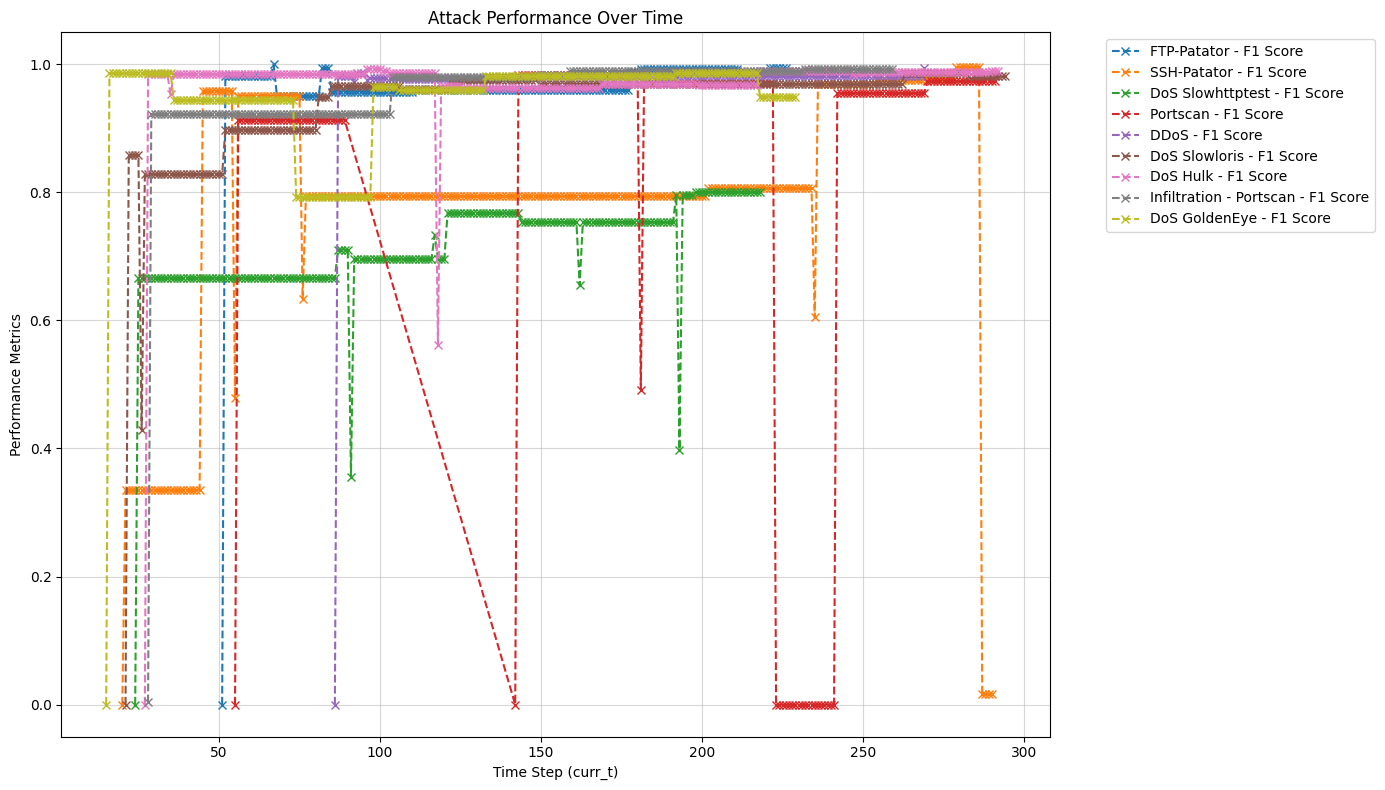

In [25]:
attack_avg_perfo = {}
for attack, data in attack_aggregates.items():
    if attack != "Infiltration - Portscan":
        # continue
        pass
    data = attack_aggregates[attack]
    # Step 1: Define the range for curr_t
    all_t_values = [t for sublist in data for t, _, _ in sublist]
    all_t_values.sort()
    min_t, max_t = min(all_t_values), max(all_t_values)

    # Step 2: Compute the average for each curr_t
    averaged_results = []

    # for curr_t in all_t_values:
    for curr_t in range(min_t,max_t):
        selected_values = []
        
        for sublist in data:
            if curr_t < sublist[0][0]:
                continue
            # Find the largest t <= curr_t in the current sublist
            valid_values = [item for item in sublist if item[0] >= curr_t]
            if valid_values:
                selected_values.append(valid_values[0])  # Use the last valid (largest t <= curr_t)
        
        if selected_values:
            # Average the selected accuracy and F1 scores
            avg_acc = np.mean([item[1] for item in selected_values])
            avg_f1 = np.mean([item[2] for item in selected_values])
            num_of_area = len(selected_values)
            averaged_results.append((curr_t, avg_acc, avg_f1, num_of_area))

    attack_avg_perfo[attack] = averaged_results

# Plot the averaged results for each attack
def plot_attack_performance(attack_avg_perfo):
    plt.figure(figsize=(14, 8))
    
    # Iterate through each attack
    for attack, performance in attack_avg_perfo.items():
        # plt.figure(figsize=(14, 8))
        # Extract data for plotting
        times = [item[0] for item in performance]
        # times = [i for i,item in enumerate(performance)]
        avg_accs = [item[1] for item in performance]
        avg_f1s = [item[2] for item in performance]
        num_areas = [item[3] for item in performance]
        
        # Plot accuracy
        # plt.plot(times, avg_accs, marker='o', label=f"{attack} - Accuracy")
        
        # Plot F1 score
        plt.plot(times, avg_f1s, marker='x', linestyle='--', label=f"{attack} - F1 Score")
        # plt.plot(times, avg_accs, marker='x', linestyle='--', label=f"{attack} - Accuracy")
        
    # Customize plot
    plt.xlabel("Time Step (curr_t)")
    plt.ylabel("Performance Metrics")
    plt.title("Attack Performance Over Time")
    plt.legend(loc="upper left", bbox_to_anchor=(1.05, 1))
    plt.grid(alpha=0.5)
    plt.tight_layout()
    plt.show()

# Call the function to plot
plot_attack_performance(attack_avg_perfo)


In [ ]:
performance

NameError: name 'performance' is not defined

### Epochs Comparison

In [ ]:
from sklearn.metrics import accuracy_score, f1_score

acc_list = []
f1_list = []

for epochs in np.arange(1, 10, 2):
    # Initialize and train the model
    clf = PReNet(device='cuda', verbose=1, epochs=epochs)
    clf.fit(X_gm_train.to_numpy(), y=y_gm_train)
    
    # Predict on the training data
    y_pred = clf.predict(X_gm_test.to_numpy())
    
    # Calculate metrics
    acc = accuracy_score(y_gm_test, y_pred)
    f1 = f1_score(y_gm_test, y_pred, average='binary')  # Use 'binary' or 'weighted' based on your label type
    
    # Store the results
    acc_list.append((epochs, acc))
    f1_list.append((epochs, f1))
    
    print(f"Epochs: {epochs}, Accuracy: {acc:.4f}, F1 Score: {f1:.4f}")


Start Training...
ensemble size: 1


KeyboardInterrupt: 

### Entire Data Accuracy

In [52]:
from sklearn.metrics import accuracy_score, f1_score

acc_list = []
f1_list = []
X_gm_train, X_gm_test, y_gm_train, y_gm_test = preprocess_data(cicids_df)
# # Initialize and train the model
clf = PReNet(device='cuda', verbose=1, epochs=1, batch_size=64)
clf.fit(X_gm_train.to_numpy(), y=y_gm_train.values)



Start Training...
ensemble size: 1


KeyboardInterrupt: 

In [ ]:
y_pred = clf.predict(X_gm_test.to_numpy())

# Calculate metrics
acc = accuracy_score(y_gm_test, y_pred)
f1 = f1_score(y_gm_test, y_pred, average='binary')  # Use 'binary' or 'weighted' based on your label type
print(acc, f1)


0.9857167712510247 0.923649259942822


### Individual Attack Accuracy

In [ ]:
clf = global_model.clf

In [ ]:
atk_info_list = define_atk(atk_list, edge_area_list, cicids_df, benign_df)
atk_acc = {}
atk_f1 = {}
atk_scores = {}
for attack in atk_info_list.values():
    print(f"__{attack.name}__")
    _, X_test, _, y_test = preprocess_data(attack.data.copy())
    y_pred = clf.predict(X_test.to_numpy())

    # Calculate metrics
    acc = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, average='binary')  # Use 'binary' or 'weighted' based on your label type    
    atk_acc[attack.name] = acc
    atk_f1[attack.name]=f1
    print(acc, f1)
    
    anomaly_scores = clf.decision_function(X_gm_test.to_numpy())
    atk_scores[attack.name] = anomaly_scores
    
    
    

__Portscan__
0.9528439759592324 0.7937964649697209
__DoS Hulk__
0.9821739403510031 0.9107028484746335
__DDoS__
0.9823961850290839 0.9117089379916271
__Infiltration - Portscan__
0.9344951982636446 0.6923882437809787
__DoS GoldenEye__
0.9887666527410296 0.9406280667320903
__FTP-Patator__
0.8738023542294004 0.16636528028933092
__DoS Slowloris__
0.9545066008167917 0.7909209951986033
__SSH-Patator__
0.8323497531012887 0.004291845493562232
__DoS Slowhttptest__
0.9651560926485397 0.8322017458777885


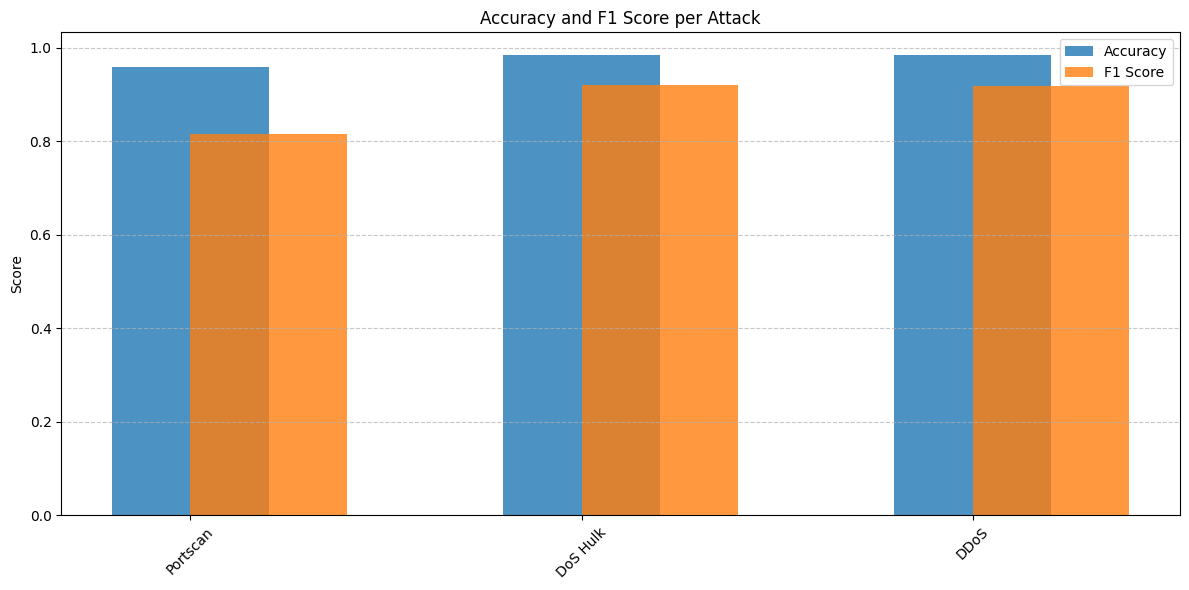

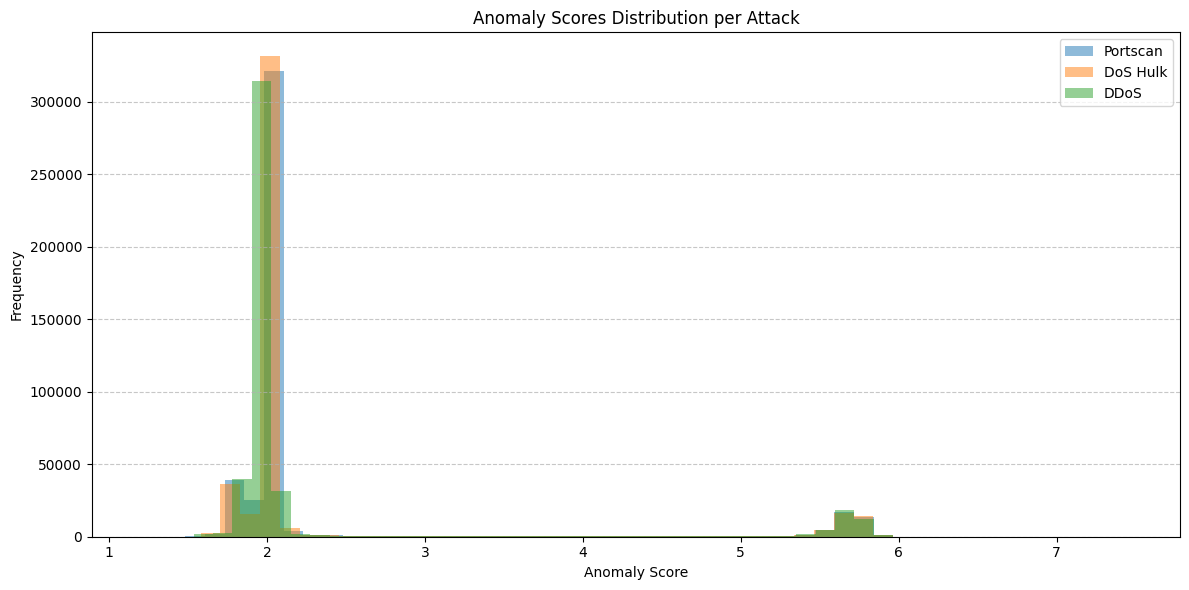

In [ ]:
import matplotlib.pyplot as plt

# Plot Accuracy and F1 Score for each attack
def plot_metrics(atk_acc, atk_f1):
    attack_names = list(atk_acc.keys())
    accuracies = list(atk_acc.values())
    f1_scores = list(atk_f1.values())

    x = range(len(attack_names))

    plt.figure(figsize=(12, 6))
    plt.bar(x, accuracies, width=0.4, label="Accuracy", align='center', alpha=0.8)
    plt.bar(x, f1_scores, width=0.4, label="F1 Score", align='edge', alpha=0.8)

    plt.xticks(x, attack_names, rotation=45)
    plt.ylabel("Score")
    plt.title("Accuracy and F1 Score per Attack")
    plt.legend()
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()

# Plot anomaly scores for each attack
def plot_anomaly_scores(atk_scores):
    plt.figure(figsize=(12, 6))

    for attack, scores in atk_scores.items():
        plt.hist(scores, bins=50, alpha=0.5, label=f"{attack}")

    plt.xlabel("Anomaly Score")
    plt.ylabel("Frequency")
    plt.title("Anomaly Scores Distribution per Attack")
    plt.legend()
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()

# Call the functions
plot_metrics(atk_acc, atk_f1)
plot_anomaly_scores(atk_scores)


<Figure size 1000x600 with 0 Axes>

(array([1.000e+00, 0.000e+00, 0.000e+00, 7.000e+00, 4.000e+00, 2.400e+01,
        1.900e+01, 4.900e+01, 1.830e+02, 1.010e+02, 6.630e+02, 2.290e+02,
        1.590e+03, 1.729e+03, 2.041e+03, 4.953e+03, 1.292e+03, 7.192e+03,
        2.695e+03, 5.684e+03, 4.922e+03, 1.984e+03, 3.829e+03, 8.820e+02,
        1.753e+03, 7.460e+02, 5.080e+02, 4.460e+02, 3.260e+02, 2.460e+02,
        2.260e+02, 1.930e+02, 1.160e+02, 1.110e+02, 7.100e+01, 4.200e+01,
        2.300e+01, 1.100e+01, 9.000e+00, 2.000e+00, 2.000e+00, 2.000e+00,
        1.000e+00, 0.000e+00, 0.000e+00, 1.000e+00, 1.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 2.000e+00, 1.000e+00, 2.000e+00,
        0.000e+00, 2.000e+00, 1.000e+00, 2.000e+00, 2.000e+00, 1.000e+00,
        0.000e+00, 1.000e+00, 0.000e+00, 1.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 1.000e+00, 1.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 3.000e+00,
        5.000e+00, 9.000e+00, 1.100e+0

(array([  1.,   2.,   0.,  12.,   3.,  20.,  26.,  29.,  50.,  19.,  85.,
         22.,  83.,  34.,  68.,  47.,  35.,  49.,  36.,  26.,  25.,  27.,
         31.,  30.,  22.,  21.,  16.,  21.,   6.,   2.,   2.,   0.,   2.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          1.,   0.,   0.,   1.,   0.,   1.,   1.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   1.,
          0.,   0.,   1.,   0.,   0.,   1.,   6.,  13.,  17.,  37.,  70.,
        102., 119., 186., 212., 294., 346., 388., 374., 377., 302., 258.,
        208., 131.,  98.,  57.,  23.,  11.,   8.,   5.,   1.,   0.,   0.,
          2.]),
 array([1.12100303, 1.17780782, 1.23461261, 1.29141739, 1.34822218,
        1.40502697, 1.46183175, 1.51863654, 1.57544133, 1.63224611,
        1.6890509 , 1.74585569, 1.80266047, 1.85946526, 1.91627005,
        1.97307484, 2.02987962, 2.08668441, 2.1434892 , 2.20029398,
        2.25709877, 2.31390356, 2.37070834, 2.

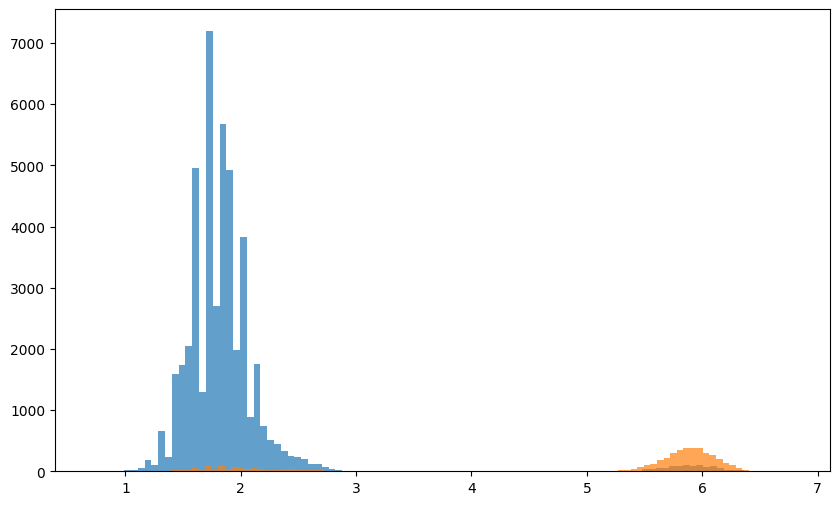

In [ ]:
scores_inliers = anomaly_scores[y_gm_test == 0]  # Assuming '0' is the label for inliers
scores_outliers = anomaly_scores[y_gm_test == 1]  # Assuming '1' is the label for outliers
# Create the plots
plt.figure(figsize=(10, 6))  # Set the figure size

# Plot for inliers
plt.hist(scores_inliers, bins=100, alpha=0.7, label='Inliers')

# Plot for outliers
plt.hist(scores_outliers, bins=100, alpha=0.7, label='Outliers')

Functions

In [ ]:

def plot_graph_scenario(metrics_dict, supervision_rate_list):
    fig, axes = plt.subplots(2,1,figsize=(14, 8))  # Create a figure and a set of subplots.
    ax_n = 0
    for metric_type in metrics_dict:
        curr_ax = axes[ax_n]
        ax_n +=1

        # Assuming metrics_dict['roc_auc'] contains the ROC AUC values for each IP
        ips = list(metrics_dict[metric_type].keys())
        n_ips = len(ips)
        n_supervision_rates = len(supervision_rate_list)

        # Create a numpy array to hold the ROC AUC values
        roc_aucs = np.zeros((n_ips, n_supervision_rates))
        
        for i, ip in enumerate(ips):
            for j, sr in enumerate(supervision_rate_list):
                roc_aucs[i, j] = metrics_dict[metric_type][ip][sr]

        # Create the bar width
        bar_width = 0.15
        index = np.arange(n_ips)

        # Plot bars for each supervision rate
        for j, sr in enumerate(supervision_rate_list):
            curr_ax.bar(index + j * bar_width, roc_aucs[:, j], bar_width, label=f'Supervision Rate: {sr}')

        curr_ax.set_title('ROC AUC Comparison by IP and Supervision Rate')
        curr_ax.set_xlabel('IP Address')
        curr_ax.set_ylabel('AUC')
        curr_ax.set_xticks(index + bar_width * (n_supervision_rates - 1) / 2)
        curr_ax.set_xticklabels(ips, rotation=45)
        curr_ax.legend()
        curr_ax.grid(True)

    plt.tight_layout()
    plt.show()

In [ ]:
from functools import partial
from modAL.batch import uncertainty_batch_sampling

def lm_eval_2(Xgmm_test_dvc, gm_pred, lm_clf):
    train_perc = 0.6
    Xlm_train, Xlm_test, ylm_train, ylm_test = train_test_split(Xgmm_test_dvc, 
                                                        gm_pred, 
                                                        test_size=1 - train_perc, 
                                                        shuffle=True, 
                                                        stratify=gm_pred, 
                                                        random_state=42)    
    if lm_clf == "Comittee":
        # initializing Committee members
        n_members = 3
        learner_list = list()
        for member_idx in range(n_members):

            # initializing learner
            learner = ActiveLearner(
                estimator=RandomForestClassifier(),
                X_training=Xlm_train, y_training=ylm_train,
            )
            learner_list.append(learner)        
        lm_clf = Committee(learner_list=learner_list)
        predictions = lm_clf.predict(Xlm_test)    
    else:
        # Train the classifier on the training data
        lm_clf.fit(Xlm_train, ylm_train)    
        
        predictions = lm_clf.predict(Xlm_test)

        
    # Evaluate accuracy
    accuracy = accuracy_score(ylm_test, predictions)
    print(f"Accuracy: {accuracy}")
    return accuracy, lm_clf, Xlm_train, ylm_train
# Read the csv and clean it
def train_gm(Xgm_train_scaled, y_train, supervision_rate, model):


    # Prepare labels for semi-supervised learning
    idx = np.where(y_train == 1)[0]
    y = np.zeros_like(y_train.values)
    y = set_supervised_label(supervision_rate, anomaly_rate, y, idx)
    # Train the model
    path = f"gm_1_{supervision_rate}.pkl"
    if os.path.exists(path):
        with open(path, 'rb') as f:
            clf = pickle.load(f)
    else:
        clf = model(device='cuda', verbose=1, epochs=1)
        clf.fit(X=Xgm_train_scaled.to_numpy(), y=y_train)  
            
            # with open(path, 'wb') as f:
                # pickle.dump(clf, f)
    return clf
def train_lm(victim_IP, Xgmm_test, y_test, scaler, gm_clf,lm_clf, method = "Normal"):
    # Load Model Instead      
    # dropping_cols = ['Protocol', 'id', 'Flow ID', 'Src IP', 'Src Port', 'Dst IP', 
    #                 'Dst Port', 'Timestamp', 'Dvc Label']            
    # Create a fresh copy of the DataFrame for each IP and supervision rate
    roc_auc, curr_X_test_scaled, gm_pred, gm_opt_threshold = perform_inference(Xgmm_test, y_test, dropping_cols, scaler, gm_clf)
    print(f"gm_opt_threshold is {gm_opt_threshold}")
    acc, updated_lm_clf, Xlm_train, Ylm_train = lm_eval_2(curr_X_test_scaled, gm_pred, lm_clf)
    return updated_lm_clf, gm_opt_threshold, Xlm_train, Ylm_train



# Perform New Attack Classification using Local Model (Obtain)
def new_attacks_inference(lm_clf, Xnew_train, ynew_train, scaler):

        cart_predictions = lm_clf.predict(Xnew_train)
        # Evaluate accuracy
        accuracy = accuracy_score(ynew_train, cart_predictions)
        print(f"Accuracy before update: {accuracy}")
        
        # Get Confidence Point
        # Get the indices of the samples where the actual label doesn't match the predicted label
        mismatch_indices = [i for i, (actual, cart_predictions) in enumerate(zip(ynew_train, cart_predictions)) if actual != cart_predictions]

        uncertain_count = 0
        cart_probabilities = lm_clf.predict_proba(Xnew_train)

        return accuracy, cart_probabilities, mismatch_indices 

def active_learning_query(lm_clf, Xnew_train, ynew_train, scaler):
    pass
    #Use Stream-Based Sampling, however instead of 1 by 1, get the whole pool

        # X_pool = Xnew_train.copy()
        # y_pool = ynew_train.copy()
        # for idx in range(n_queries):
        #     query_idx, query_instance = lm_clf.query(X_pool)
        #     lm_clf.teach(
        #         X=X_pool[query_idx].reshape(1, -1),
        #         y=y_pool[query_idx].reshape(1, )
        #     )
        #     performance_history.append(lm_clf.score())
        #     # remove queried instance from pool
        #     X_pool = np.delete(X_pool, query_idx, axis=0)
        #     y_pool = np.delete(y_pool, query_idx)     
        # predictions = lm_clf.predict(X_pool)     
        
    

# Forward Low confidence data to GM and Label (Get GM Accuracy)
def get_low_confidence_data(cart_probabilities, mismatch_indices, threshold=1):
    if threshold == 1:
        forward_gm_idx = np.where((cart_probabilities[:, 0] != threshold) & (cart_probabilities[:, 0] !=  threshold))
    else: 
        forward_gm_idx = np.where((cart_probabilities[:, 0] > threshold) & (cart_probabilities[:, 0] <  1-threshold))
    print(f"Total Uploaded Data {len(forward_gm_idx[0])}")
    # How many Misclassified data is inconfident
    set_mismatch_indices = set(list(mismatch_indices))
    set_forward_gm_idx = set(forward_gm_idx[0].tolist())
    x = len(set_mismatch_indices.intersection(set_forward_gm_idx))
    print(f"Percentage of misclassied data that is uploaded: {x/len(mismatch_indices)}")
    print(f"Total Data Uploaded: {len(forward_gm_idx[0])/len(cart_probabilities)}")
    # print(f"Correctly Detected / Uploaded data: {(x/len(forward_gm_idx[0]))}")  
    return forward_gm_idx

# Upload to label and Perform Training on CART_Classifier
def upload_gm(X_forward, y_forward, gm_clf, lm_clf, gm_opt_threshold, orig_Xlm_train, orig_Ylm_train):
    anomaly_scores = gm_clf.decision_function(X=X_forward)
    initial_gm_pred = np.where(anomaly_scores > gm_opt_threshold, 1,0)
    accuracy = accuracy_score(y_forward, initial_gm_pred)
    print(f'Accuracy of GM before update: {accuracy}')
    
    # Convert numpy arrays to DataFrames
    X_forward_df = pd.DataFrame(X_forward, columns = orig_Xlm_train.columns )
    y_forward_df = pd.DataFrame(np.zeros(initial_gm_pred.shape[0]), columns=["Label"])

    # Concatenate with original DataFrames
    Xtrain = pd.concat([pd.DataFrame(orig_Xlm_train), X_forward_df], axis=0)
    Ytrain = pd.concat([pd.DataFrame(orig_Ylm_train, columns=["Label"]), y_forward_df])
    Xtrain.columns = orig_Xlm_train.columns
    # return Xtrain, Ytrain
    # Update GM
    gm_clf = train_gm(orig_Xlm_train, orig_Ylm_train, supervision_rate, PReNet)
    # Inference using updated GM
    anomaly_scores = gm_clf.decision_function(X=X_forward)
    updated_gm_pred = np.where(anomaly_scores > gm_opt_threshold, 1,0)
    accuracy = accuracy_score(y_forward, updated_gm_pred)
    print(f'Accuracy of GM after update: {accuracy}')  
    
    Ytrain = pd.concat([pd.DataFrame(orig_Ylm_train, columns=["Label"]), pd.DataFrame(updated_gm_pred, columns=["Label"])])  
    lm_clf = XGBClassifier(objective='binary:logistic', n_estimators=100, learning_rate=0.1)
    # continued_model.fit(X_forward_df, y_forward_df, xgb_model=lm_clf.get_booster())    
    # continued_model.fit(Xtrain, Ytrain)
    lm_clf.fit(Xtrain, Ytrain)
    return lm_clf
# Evaluate Accuracy with new attack data
def eval_updated_lm(Xnew_test, ynew_test, new_lm_clf):
    pred = new_lm_clf.predict(Xnew_test)
    acc = accuracy_score(ynew_test, pred)
    print(f'Accuracy of updated LM: {acc}')


ModuleNotFoundError: No module named 'modAL'

In [ ]:
# Read the csv and clean it
def eval_model_unsupervised(improved_df, supervision_rate_list, model, victim_IP):
    anomaly_rate = 0.05
    metrics_dict = {
        'roc_auc': {ip : {sr : 0 for sr in supervision_rate_list} for ip in victim_IP}
    }
    X_train, X_test, y_train, y_test, scaler = process_dataset(improved_df, anomaly_rate)

    for supervision_rate in supervision_rate_list:
        # Prepare labels for semi-supervised learning
        idx = np.where(y_train == 1)[0]
        y = np.zeros_like(y_train.values)

        y = set_supervised_label(supervision_rate, anomaly_rate, y, idx)
            
        dropping_cols = ['Protocol', 'id', 'Flow ID', 'Src IP', 'Src Port', 'Dst IP', 
                        'Dst Port', 'Timestamp', 'Dvc Label']
        X_train.drop(dropping_cols, axis = 1, inplace = True)     
        
        X_train_scaled = scaler.fit_transform(X_train)
        X_train_scaled = pd.DataFrame(X_train_scaled, columns=X_train.columns) 
        
        # Train the model
        clf = model(device='cuda', verbose=1, epochs=1)
        clf.fit(X=X_train_scaled.to_numpy(), y=y)        
        
        for curr_ip in victim_IP:
            # Create a fresh copy of the DataFrame for each IP and supervision rate

            roc_auc = perform_inference(X_test, y_test, curr_ip, dropping_cols, scaler, clf)
            # Store metrics
            metrics_dict['roc_auc'][curr_ip][supervision_rate] += roc_auc 

    return metrics_dict


# Fixing Accuracy

In [ ]:
from sklearn import metrics
def get_score(y_true, y_pred):
  accuracy = accuracy_score(y_true, y_pred)
  precision = precision_score(y_true, y_pred)
  recall = recall_score(y_true, y_pred)
  f1 = f1_score(y_true, y_pred)
  confusion_matrix = metrics.confusion_matrix(y_true, y_pred)

  print(f"Accuracy: {accuracy:.4f}")
  print(f"Precision: {precision:.4f}")
  print(f"Recall: {recall:.4f}")
  print(f"F1 Score: {f1:.4f}")
  print(confusion_matrix)
  
# Read the csv and clean it
  
  
df = read_csv()
df = pd.concat([df[df['Label'] == 'BENIGN'], df[df['Label'] != 'BENIGN'].sample(frac=0.3, random_state=42)]) 
ratio = df.loc[df["Label"] == "BENIGN"].shape[0]/ df.loc[df["Label"] != "BENIGN"].shape[0]
print(f'Ratio of Benign to Anomaly is {ratio} : 1')
def eval_model_unsupervised(supervision_rate_list, model):
  anomaly_rate = 1.0
  for supervision_rate in supervision_rate_list:
    # supervision = False
    improved_df = df.copy()


    X_train, X_test, y_train, y_test = preprocess_data(improved_df)
    # Start Training
    idx = np.where(y_train==1)[0]
    y = np.zeros_like(y_train.values)
    if supervision_rate == 0:
      print(f"UNSUPERVISED, Sampling Rate = {anomaly_rate}")
      y[idx[:2]] = 1
    else:
      print(f"SEMI SUPERVISED, Sampling Rate = {anomaly_rate}, Supervision = {supervision_rate}")
      idx = np.random.choice(idx, size=int(supervision_rate*len(idx)), replace=False)
      y[idx] = 1
    
    clf = model( device = 'cuda', verbose=1, epochs=1)
    clf.fit(X=X_train.to_numpy(), y = y)
    # pred = clf.predict(X_test.to_numpy())
    anomaly_scores = clf.decision_function(X_test.to_numpy())

    fpr, tpr, _ = roc_curve(y_test, anomaly_scores)
    precision, recall, thresholds = precision_recall_curve(y_test, anomaly_scores)
    opt_threshold = get_optimal_threshold(precision, recall, thresholds)
    pred = np.where(anomaly_scores > opt_threshold, 1,0)
    accuracy = accuracy_score(y_test, pred)
    get_score(pred, y_test)
    

supervision_rate_list = [1.0, 0.5, 0.25, 0.1, 0.05, 0.0]

model = PReNet
eval_model_unsupervised(supervision_rate_list, model)


dataset shape (2099976, 91)
zero variance columns [] dropped
shape after removing zero variance columns: (2099976, 91)
5 rows dropped
shape after removing nan: (2099971, 91)
shape after dropping duplicates: (2099971, 91)
columns which have identical values [] dropped
shape after removing identical value columns: (2099971, 91)
SEMI SUPERVISED, Sampling Rate = 1.0, Supervision = 1.0
Start Training...
ensemble size: 1
epoch  1, training loss: 0.135584, time: 276.3s
Start Inference on the training data...
Accuracy: 0.9964
Precision: 0.9867
Recall: 0.9981
F1 Score: 0.9924
[[1354556    5696]
 [    803  423921]]
SEMI SUPERVISED, Sampling Rate = 1.0, Supervision = 0.5
Start Training...
ensemble size: 1


KeyboardInterrupt: 